In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse



In [ ]:
torch.cuda.is_available()

In [3]:
# for cpu user only
torch.set_num_threads(40)

In [5]:
input_path = "./10x_pbmc/"
output_path = "./10x_pbmc/scMVP_output/"
n_epochs_all = None
show_plot = True
test_mode = False

tenx_pbmc_dataset = {
                "gene_names": '10x_pbmc_scale_gene.txt',
                "gene_expression": '10x_pbmc_rna_normalize_count.mtx',
                "gene_barcodes": '10x_pbmc_cell_barcode.txt',
                "atac_names": '10x_pbmc_peak.txt',
                "atac_expression": '10x_pbmc_atac_normalize_count.mtx',
                "atac_barcodes": '10x_pbmc_cell_barcode.txt'
                }
dataset = LoadData(dataset=tenx_pbmc_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2021-07-20 21:54:53,657] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-07-20 21:57:14,110] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-07-20 21:57:14,252] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-07-20 21:57:14,254] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-07-20 21:57:17,442] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-07-20 21:57:17,500] INFO - scMVP.dataset.dataset | Downsampled from 10412 to 10412 cells


In [ ]:
## manual check the input RNA and ATAC profile, both RNA and ATAC should not contain "NA"!
print(dataset.X.shape) # scRNA profile
print(dataset.atac_expression.shape) # scATAC profile

In [ ]:
dataset.X

In [ ]:
dataset.atac_expression

In [6]:
##### 
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0
n_centroids=8

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.exists("{}/multi_vae_trainer_no_pretrain.pkl".format(output_path)):
    trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer_no_pretrain.pkl".format(output_path)))
    trainer.model.eval()
else:
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_no_pretrain.pkl' % output_path)
    trainer.model.eval()

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

training:   0%|          | 0/15 [00:00<?, ?it/s]logpzc:-94.44705963134766, logqcx:-2.0794413089752197
kld_qz_pz = 53.436852,kld_qz_rna = 5.913224,kld_qz_atac = 5.145543,kl_divergence = 53.951481,reconst_loss_rna = 9221.527344,        reconst_loss_atac = 1199.680664, mu=0.000000, sigma=1.000000
reconst_loss = 10471.576172,kl_divergence_local = 53.951481,kl_weight = 1.000000,loss = 10525.528320
tensor(10525.5283, grad_fn=<DivBackward0>)
logpzc:-47.406410217285156, logqcx:-2.0794413089752197
kld_qz_pz = 11.908557,kld_qz_rna = 10.084898,kld_qz_atac = 8.737218,kl_divergence = 12.806945,reconst_loss_rna = 8479.119141,        reconst_loss_atac = 1293.654663, mu=0.000080, sigma=1.004772
reconst_loss = 9823.142578,kl_divergence_local = 12.806945,kl_weight = 1.000000,loss = 9835.949219
tensor(9835.9492, grad_fn=<DivBackward0>)
logpzc:-51.058204650878906, logqcx:-2.0794413089752197
kld_qz_pz = 17.392220,kld_qz_rna = 20.244999,kld_qz_atac = 19.009075,kl_divergence = 19.132532,reconst_loss_rna = 69

logpzc:-51.80985641479492, logqcx:-2.0794413089752197
kld_qz_pz = 20.508280,kld_qz_rna = 76.869072,kld_qz_atac = 59.210442,kl_divergence = 22.289633,reconst_loss_rna = 4634.523438,        reconst_loss_atac = 1212.161255, mu=-0.000130, sigma=1.083939
reconst_loss = 5897.052246,kl_divergence_local = 22.289633,kl_weight = 1.000000,loss = 5919.341797
tensor(5919.3418, grad_fn=<DivBackward0>)
logpzc:-50.137107849121094, logqcx:-2.0794413089752197
kld_qz_pz = 18.718264,kld_qz_rna = 82.604012,kld_qz_atac = 53.464809,kl_divergence = 20.427280,reconst_loss_rna = 4324.389160,        reconst_loss_atac = 1052.358276, mu=-0.000114, sigma=1.087445
reconst_loss = 5427.115723,kl_divergence_local = 20.427280,kl_weight = 1.000000,loss = 5447.542969
tensor(5447.5430, grad_fn=<DivBackward0>)
logpzc:-48.88899612426758, logqcx:-2.0794413089752197
kld_qz_pz = 17.280737,kld_qz_rna = 72.554146,kld_qz_atac = 50.981308,kl_divergence = 18.930267,reconst_loss_rna = 4311.272461,        reconst_loss_atac = 1009.3574

logpzc:-41.74860382080078, logqcx:-2.0794413089752197
kld_qz_pz = 11.026960,kld_qz_rna = 55.082962,kld_qz_atac = 39.135788,kl_divergence = 13.382469,reconst_loss_rna = 4152.231934,        reconst_loss_atac = 1010.832458, mu=0.004597, sigma=1.146642
reconst_loss = 5213.432617,kl_divergence_local = 13.382469,kl_weight = 1.000000,loss = 5226.815430
tensor(5226.8154, grad_fn=<DivBackward0>)
logpzc:-41.36176300048828, logqcx:-2.0794413089752197
kld_qz_pz = 10.637131,kld_qz_rna = 52.978374,kld_qz_atac = 38.837074,kl_divergence = 13.032541,reconst_loss_rna = 4201.875488,        reconst_loss_atac = 980.429199, mu=0.004878, sigma=1.148826
reconst_loss = 5232.672852,kl_divergence_local = 13.032541,kl_weight = 1.000000,loss = 5245.705078
tensor(5245.7051, grad_fn=<DivBackward0>)
logpzc:-40.91644287109375, logqcx:-2.0794413089752197
kld_qz_pz = 10.220524,kld_qz_rna = 50.772861,kld_qz_atac = 38.986580,kl_divergence = 12.665596,reconst_loss_rna = 4182.010254,        reconst_loss_atac = 1044.807983, 

logpzc:-39.125125885009766, logqcx:-2.0794413089752197
kld_qz_pz = 9.027893,kld_qz_rna = 63.792099,kld_qz_atac = 44.678051,kl_divergence = 11.668038,reconst_loss_rna = 4163.466309,        reconst_loss_atac = 1027.669434, mu=0.011120, sigma=1.189429
reconst_loss = 5241.503906,kl_divergence_local = 11.668038,kl_weight = 1.000000,loss = 5253.171387
tensor(5253.1714, grad_fn=<DivBackward0>)
logpzc:-40.19325256347656, logqcx:-2.0794413089752197
kld_qz_pz = 10.043694,kld_qz_rna = 72.874649,kld_qz_atac = 46.758354,kl_divergence = 12.662248,reconst_loss_rna = 4097.162598,        reconst_loss_atac = 1013.434814, mu=0.011338, sigma=1.191149
reconst_loss = 5160.965332,kl_divergence_local = 12.662248,kl_weight = 1.000000,loss = 5173.627930
tensor(5173.6279, grad_fn=<DivBackward0>)
logpzc:-40.09510040283203, logqcx:-2.0794413089752197
kld_qz_pz = 9.932665,kld_qz_rna = 88.426437,kld_qz_atac = 48.704964,kl_divergence = 12.571785,reconst_loss_rna = 4062.598145,        reconst_loss_atac = 895.154785, m

logpzc:-38.11613464355469, logqcx:-2.0794413089752197
kld_qz_pz = 8.091326,kld_qz_rna = 83.584923,kld_qz_atac = 51.554176,kl_divergence = 11.156569,reconst_loss_rna = 4128.128906,        reconst_loss_atac = 981.878479, mu=0.017594, sigma=1.225118
reconst_loss = 5160.375488,kl_divergence_local = 11.156569,kl_weight = 1.000000,loss = 5171.532227
tensor(5171.5322, grad_fn=<DivBackward0>)
logpzc:-37.812713623046875, logqcx:-2.0794410705566406
kld_qz_pz = 7.826423,kld_qz_rna = 64.366562,kld_qz_atac = 51.448399,kl_divergence = 10.768987,reconst_loss_rna = 4133.139648,        reconst_loss_atac = 1036.198975, mu=0.017922, sigma=1.226544
reconst_loss = 5219.706055,kl_divergence_local = 10.768987,kl_weight = 1.000000,loss = 5230.475098
tensor(5230.4751, grad_fn=<DivBackward0>)
logpzc:-37.79429244995117, logqcx:-2.0794410705566406
kld_qz_pz = 7.779816,kld_qz_rna = 65.884491,kld_qz_atac = 50.499470,kl_divergence = 10.612667,reconst_loss_rna = 4030.955078,        reconst_loss_atac = 894.833801, mu=

logpzc:-37.92041015625, logqcx:-2.0794408321380615
kld_qz_pz = 7.910714,kld_qz_rna = 71.609863,kld_qz_atac = 57.696270,kl_divergence = 10.743254,reconst_loss_rna = 4057.979980,        reconst_loss_atac = 1019.426880, mu=0.020628, sigma=1.255892
reconst_loss = 5127.774902,kl_divergence_local = 10.743254,kl_weight = 1.000000,loss = 5138.518555
tensor(5138.5186, grad_fn=<DivBackward0>)
logpzc:-38.14799499511719, logqcx:-2.0794382095336914
kld_qz_pz = 8.092574,kld_qz_rna = 86.227707,kld_qz_atac = 55.866993,kl_divergence = 10.940277,reconst_loss_rna = 3963.056641,        reconst_loss_atac = 882.473755, mu=0.020672, sigma=1.257356
reconst_loss = 4895.898926,kl_divergence_local = 10.940277,kl_weight = 1.000000,loss = 4906.838867
tensor(4906.8389, grad_fn=<DivBackward0>)
logpzc:-37.60380935668945, logqcx:-2.0794405937194824
kld_qz_pz = 7.597119,kld_qz_rna = 70.746323,kld_qz_atac = 57.518547,kl_divergence = 10.344350,reconst_loss_rna = 4060.918701,        reconst_loss_atac = 1012.355652, mu=0.0

logpzc:-36.16739273071289, logqcx:-2.0794126987457275
kld_qz_pz = 6.167349,kld_qz_rna = 83.396896,kld_qz_atac = 53.747726,kl_divergence = 9.053966,reconst_loss_rna = 3977.535645,        reconst_loss_atac = 996.111572, mu=0.023370, sigma=1.281458
reconst_loss = 5024.015137,kl_divergence_local = 9.053966,kl_weight = 1.000000,loss = 5033.068848
tensor(5033.0688, grad_fn=<DivBackward0>)
logpzc:-36.10623550415039, logqcx:-2.079423666000366
kld_qz_pz = 6.112255,kld_qz_rna = 80.614540,kld_qz_atac = 55.371639,kl_divergence = 8.972796,reconst_loss_rna = 3927.051758,        reconst_loss_atac = 924.322876, mu=0.023476, sigma=1.282470
reconst_loss = 4901.742676,kl_divergence_local = 8.972796,kl_weight = 1.000000,loss = 4910.715820
tensor(4910.7158, grad_fn=<DivBackward0>)
logpzc:-36.27251052856445, logqcx:-2.0794360637664795
kld_qz_pz = 6.261289,kld_qz_rna = 82.740379,kld_qz_atac = 55.448353,kl_divergence = 9.128454,reconst_loss_rna = 3912.289307,        reconst_loss_atac = 918.088684, mu=0.023563

logpzc:-35.8577995300293, logqcx:-2.079439401626587
kld_qz_pz = 5.856212,kld_qz_rna = 69.239624,kld_qz_atac = 52.002228,kl_divergence = 9.137966,reconst_loss_rna = 4126.476562,        reconst_loss_atac = 995.985046, mu=0.026157, sigma=1.303277
reconst_loss = 5172.829102,kl_divergence_local = 9.137966,kl_weight = 1.000000,loss = 5181.967285
tensor(5181.9673, grad_fn=<DivBackward0>)
logpzc:-36.442237854003906, logqcx:-2.079439401626587
kld_qz_pz = 6.434511,kld_qz_rna = 73.849823,kld_qz_atac = 52.879150,kl_divergence = 9.740608,reconst_loss_rna = 4125.380859,        reconst_loss_atac = 1042.506592, mu=0.026299, sigma=1.304240
reconst_loss = 5218.255859,kl_divergence_local = 9.740608,kl_weight = 1.000000,loss = 5227.996094
tensor(5227.9961, grad_fn=<DivBackward0>)
logpzc:-36.14128875732422, logqcx:-2.079439878463745
kld_qz_pz = 6.130607,kld_qz_rna = 72.089180,kld_qz_atac = 52.184513,kl_divergence = 9.212543,reconst_loss_rna = 3984.256348,        reconst_loss_atac = 921.810669, mu=0.026446,

logpzc:-35.37786102294922, logqcx:-2.0794363021850586
kld_qz_pz = 5.353560,kld_qz_rna = 103.580627,kld_qz_atac = 52.101517,kl_divergence = 8.474197,reconst_loss_rna = 3906.817871,        reconst_loss_atac = 949.485229, mu=0.028871, sigma=1.323010
reconst_loss = 4906.671875,kl_divergence_local = 8.474197,kl_weight = 1.000000,loss = 4915.145996
tensor(4915.1460, grad_fn=<DivBackward0>)
logpzc:-35.42859649658203, logqcx:-2.0794382095336914
kld_qz_pz = 5.411902,kld_qz_rna = 85.256828,kld_qz_atac = 52.864273,kl_divergence = 8.624302,reconst_loss_rna = 4106.094238,        reconst_loss_atac = 1094.024780, mu=0.029012, sigma=1.323821
reconst_loss = 5250.486816,kl_divergence_local = 8.624302,kl_weight = 1.000000,loss = 5259.111328
tensor(5259.1113, grad_fn=<DivBackward0>)
logpzc:-35.38668441772461, logqcx:-2.0794379711151123
kld_qz_pz = 5.357969,kld_qz_rna = 90.251953,kld_qz_atac = 52.309422,kl_divergence = 8.431864,reconst_loss_rna = 3959.380859,        reconst_loss_atac = 942.949219, mu=0.029

logpzc:-35.378753662109375, logqcx:-2.0794384479522705
kld_qz_pz = 5.330142,kld_qz_rna = 100.615738,kld_qz_atac = 53.672108,kl_divergence = 8.417869,reconst_loss_rna = 4003.338623,        reconst_loss_atac = 1035.434937, mu=0.031746, sigma=1.339250
reconst_loss = 5089.141602,kl_divergence_local = 8.417869,kl_weight = 1.000000,loss = 5097.559570
tensor(5097.5596, grad_fn=<DivBackward0>)
logpzc:-35.25998306274414, logqcx:-2.0794339179992676
kld_qz_pz = 5.208459,kld_qz_rna = 90.741898,kld_qz_atac = 52.489826,kl_divergence = 8.323459,reconst_loss_rna = 3910.853027,        reconst_loss_atac = 936.983154, mu=0.031849, sigma=1.339939
reconst_loss = 4898.204102,kl_divergence_local = 8.323459,kl_weight = 1.000000,loss = 4906.526855
tensor(4906.5269, grad_fn=<DivBackward0>)
logpzc:-35.41889190673828, logqcx:-2.0794382095336914
kld_qz_pz = 5.366721,kld_qz_rna = 94.062340,kld_qz_atac = 52.691372,kl_divergence = 8.519877,reconst_loss_rna = 3950.175293,        reconst_loss_atac = 943.595703, mu=0.03

logpzc:-34.57111740112305, logqcx:-2.079421281814575
kld_qz_pz = 4.511916,kld_qz_rna = 96.886055,kld_qz_atac = 54.876442,kl_divergence = 7.629694,reconst_loss_rna = 3955.152588,        reconst_loss_atac = 1059.577148, mu=0.033479, sigma=1.352195
reconst_loss = 5065.097656,kl_divergence_local = 7.629694,kl_weight = 1.000000,loss = 5072.727539
tensor(5072.7275, grad_fn=<DivBackward0>)
logpzc:-34.575477600097656, logqcx:-2.07942795753479
kld_qz_pz = 4.510095,kld_qz_rna = 92.151627,kld_qz_atac = 54.814129,kl_divergence = 7.727246,reconst_loss_rna = 3892.893555,        reconst_loss_atac = 913.752930, mu=0.033590, sigma=1.352853
reconst_loss = 4857.014160,kl_divergence_local = 7.727246,kl_weight = 1.000000,loss = 4864.741211
tensor(4864.7412, grad_fn=<DivBackward0>)
logpzc:-34.6270637512207, logqcx:-2.079423427581787
kld_qz_pz = 4.565025,kld_qz_rna = 83.725121,kld_qz_atac = 54.903313,kl_divergence = 8.045673,reconst_loss_rna = 3994.303955,        reconst_loss_atac = 1028.937988, mu=0.033694,

logpzc:-34.07718276977539, logqcx:-2.079425096511841
kld_qz_pz = 4.002697,kld_qz_rna = 123.182755,kld_qz_atac = 54.861633,kl_divergence = 7.167633,reconst_loss_rna = 3891.296875,        reconst_loss_atac = 953.774536, mu=0.034799, sigma=1.364201
reconst_loss = 4895.439453,kl_divergence_local = 7.167633,kl_weight = 1.000000,loss = 4902.606934
tensor(4902.6069, grad_fn=<DivBackward0>)
logpzc:-33.896522521972656, logqcx:-2.0794153213500977
kld_qz_pz = 3.821382,kld_qz_rna = 109.133255,kld_qz_atac = 54.963840,kl_divergence = 7.173870,reconst_loss_rna = 3896.894531,        reconst_loss_atac = 921.953247, mu=0.034871, sigma=1.364715
reconst_loss = 4869.215820,kl_divergence_local = 7.173870,kl_weight = 1.000000,loss = 4876.389160
tensor(4876.3892, grad_fn=<DivBackward0>)
logpzc:-33.827178955078125, logqcx:-2.0794107913970947
kld_qz_pz = 3.751078,kld_qz_rna = 130.534943,kld_qz_atac = 55.519764,kl_divergence = 6.999247,reconst_loss_rna = 3826.563477,        reconst_loss_atac = 923.513062, mu=0.0

logpzc:-33.670475006103516, logqcx:-2.0793278217315674
kld_qz_pz = 3.573867,kld_qz_rna = 105.480072,kld_qz_atac = 55.261562,kl_divergence = 6.896739,reconst_loss_rna = 3970.473633,        reconst_loss_atac = 1057.088257, mu=0.036034, sigma=1.373107
reconst_loss = 5077.929199,kl_divergence_local = 6.896739,kl_weight = 1.000000,loss = 5084.825195
tensor(5084.8252, grad_fn=<DivBackward0>)
logpzc:-33.762977600097656, logqcx:-2.0793516635894775
kld_qz_pz = 3.663941,kld_qz_rna = 119.346100,kld_qz_atac = 55.080044,kl_divergence = 7.109656,reconst_loss_rna = 3813.923340,        reconst_loss_atac = 921.639587, mu=0.036131, sigma=1.373523
reconst_loss = 4785.929688,kl_divergence_local = 7.109656,kl_weight = 1.000000,loss = 4793.039551
tensor(4793.0396, grad_fn=<DivBackward0>)
logpzc:-34.10345458984375, logqcx:-2.079404592514038
kld_qz_pz = 4.004484,kld_qz_rna = 118.310051,kld_qz_atac = 55.304436,kl_divergence = 7.500073,reconst_loss_rna = 4019.208008,        reconst_loss_atac = 979.201904, mu=0.

logpzc:-34.071895599365234, logqcx:-2.0794179439544678
kld_qz_pz = 3.943164,kld_qz_rna = 88.784035,kld_qz_atac = 55.025307,kl_divergence = 7.388977,reconst_loss_rna = 3919.028320,        reconst_loss_atac = 966.750977, mu=0.037954, sigma=1.381553
reconst_loss = 4936.147461,kl_divergence_local = 7.388977,kl_weight = 1.000000,loss = 4943.536133
tensor(4943.5361, grad_fn=<DivBackward0>)
logpzc:-33.740299224853516, logqcx:-2.0794148445129395
kld_qz_pz = 3.614634,kld_qz_rna = 87.015610,kld_qz_atac = 55.624786,kl_divergence = 7.032117,reconst_loss_rna = 3980.994629,        reconst_loss_atac = 1033.643677, mu=0.038059, sigma=1.381927
reconst_loss = 5065.005859,kl_divergence_local = 7.032117,kl_weight = 1.000000,loss = 5072.038086
tensor(5072.0381, grad_fn=<DivBackward0>)
logpzc:-33.78037643432617, logqcx:-2.079399585723877
kld_qz_pz = 3.656733,kld_qz_rna = 81.712761,kld_qz_atac = 56.066841,kl_divergence = 7.489225,reconst_loss_rna = 4120.791504,        reconst_loss_atac = 1175.771362, mu=0.03

logpzc:-34.13908004760742, logqcx:-2.079373598098755
kld_qz_pz = 3.988461,kld_qz_rna = 100.199615,kld_qz_atac = 57.236866,kl_divergence = 7.571348,reconst_loss_rna = 3936.600342,        reconst_loss_atac = 942.282043, mu=0.039297, sigma=1.386545
reconst_loss = 4929.249023,kl_divergence_local = 7.571348,kl_weight = 1.000000,loss = 4936.820801
tensor(4936.8208, grad_fn=<DivBackward0>)
logpzc:-34.149723052978516, logqcx:-2.0793566703796387
kld_qz_pz = 3.995286,kld_qz_rna = 122.636826,kld_qz_atac = 57.005291,kl_divergence = 7.445629,reconst_loss_rna = 3886.665771,        reconst_loss_atac = 1012.071899, mu=0.039335, sigma=1.387014
reconst_loss = 4949.104980,kl_divergence_local = 7.445629,kl_weight = 1.000000,loss = 4956.550293
tensor(4956.5503, grad_fn=<DivBackward0>)
logpzc:-34.11380386352539, logqcx:-2.079369068145752
kld_qz_pz = 3.957747,kld_qz_rna = 129.181473,kld_qz_atac = 56.883774,kl_divergence = 7.500037,reconst_loss_rna = 3891.317139,        reconst_loss_atac = 897.941528, mu=0.03

logpzc:-34.240501403808594, logqcx:-2.0794053077697754
kld_qz_pz = 4.060899,kld_qz_rna = 124.361679,kld_qz_atac = 56.416988,kl_divergence = 7.371527,reconst_loss_rna = 3838.742188,        reconst_loss_atac = 973.341187, mu=0.040170, sigma=1.395679
reconst_loss = 4862.451172,kl_divergence_local = 7.371527,kl_weight = 1.000000,loss = 4869.822754
tensor(4869.8228, grad_fn=<DivBackward0>)
logpzc:-34.42122268676758, logqcx:-2.0794143676757812
kld_qz_pz = 4.241908,kld_qz_rna = 116.440208,kld_qz_atac = 56.528111,kl_divergence = 7.605626,reconst_loss_rna = 3878.622070,        reconst_loss_atac = 1013.429871, mu=0.040236, sigma=1.396207
reconst_loss = 4942.419434,kl_divergence_local = 7.605626,kl_weight = 1.000000,loss = 4950.024902
tensor(4950.0249, grad_fn=<DivBackward0>)
logpzc:-34.33406066894531, logqcx:-2.079397678375244
kld_qz_pz = 4.152758,kld_qz_rna = 115.893692,kld_qz_atac = 56.455372,kl_divergence = 7.534793,reconst_loss_rna = 3939.183105,        reconst_loss_atac = 999.148071, mu=0.0

logpzc:-33.688629150390625, logqcx:-2.0793638229370117
kld_qz_pz = 3.489717,kld_qz_rna = 91.518257,kld_qz_atac = 56.483032,kl_divergence = 6.836683,reconst_loss_rna = 3959.925293,        reconst_loss_atac = 1014.715698, mu=0.040979, sigma=1.403119
reconst_loss = 5025.007812,kl_divergence_local = 6.836683,kl_weight = 1.000000,loss = 5031.845215
tensor(5031.8452, grad_fn=<DivBackward0>)
logpzc:-33.60419464111328, logqcx:-2.079352617263794
kld_qz_pz = 3.403325,kld_qz_rna = 95.487976,kld_qz_atac = 56.510780,kl_divergence = 6.841811,reconst_loss_rna = 3798.679688,        reconst_loss_atac = 977.290833, mu=0.040997, sigma=1.403331
reconst_loss = 4826.336914,kl_divergence_local = 6.841811,kl_weight = 1.000000,loss = 4833.178711
tensor(4833.1787, grad_fn=<DivBackward0>)
logpzc:-33.7420539855957, logqcx:-2.079379081726074
kld_qz_pz = 3.538520,kld_qz_rna = 119.351662,kld_qz_atac = 56.773178,kl_divergence = 7.015191,reconst_loss_rna = 3898.798584,        reconst_loss_atac = 950.536194, mu=0.04101

logpzc:-33.67036819458008, logqcx:-2.079393148422241
kld_qz_pz = 3.441572,kld_qz_rna = 99.713547,kld_qz_atac = 55.728310,kl_divergence = 6.969534,reconst_loss_rna = 3854.528564,        reconst_loss_atac = 971.517212, mu=0.041912, sigma=1.408788
reconst_loss = 4876.413574,kl_divergence_local = 6.969534,kl_weight = 1.000000,loss = 4883.382812
tensor(4883.3828, grad_fn=<DivBackward0>)
logpzc:-33.661277770996094, logqcx:-2.079385995864868
kld_qz_pz = 3.429791,kld_qz_rna = 82.546242,kld_qz_atac = 55.550621,kl_divergence = 6.958938,reconst_loss_rna = 3802.195801,        reconst_loss_atac = 953.683716, mu=0.042000, sigma=1.409203
reconst_loss = 4806.247070,kl_divergence_local = 6.958938,kl_weight = 1.000000,loss = 4813.206055
tensor(4813.2061, grad_fn=<DivBackward0>)
logpzc:-33.82246398925781, logqcx:-2.079404592514038
kld_qz_pz = 3.590199,kld_qz_rna = 80.688873,kld_qz_atac = 56.196880,kl_divergence = 7.179689,reconst_loss_rna = 3814.423828,        reconst_loss_atac = 1071.078003, mu=0.042098

logpzc:-33.869571685791016, logqcx:-2.079399347305298
kld_qz_pz = 3.619447,kld_qz_rna = 83.039085,kld_qz_atac = 55.719559,kl_divergence = 7.246614,reconst_loss_rna = 3948.728271,        reconst_loss_atac = 1062.837158, mu=0.043692, sigma=1.414231
reconst_loss = 5061.932617,kl_divergence_local = 7.246614,kl_weight = 1.000000,loss = 5069.179688
tensor(5069.1797, grad_fn=<DivBackward0>)
logpzc:-33.69285583496094, logqcx:-2.079349994659424
kld_qz_pz = 3.442403,kld_qz_rna = 87.407349,kld_qz_atac = 55.707794,kl_divergence = 6.930952,reconst_loss_rna = 3845.520996,        reconst_loss_atac = 990.913452, mu=0.043741, sigma=1.414396
reconst_loss = 4886.801758,kl_divergence_local = 6.930952,kl_weight = 1.000000,loss = 4893.731934
tensor(4893.7319, grad_fn=<DivBackward0>)
logpzc:-33.58784484863281, logqcx:-2.0792970657348633
kld_qz_pz = 3.336091,kld_qz_rna = 92.943886,kld_qz_atac = 55.361378,kl_divergence = 6.787130,reconst_loss_rna = 3866.649170,        reconst_loss_atac = 923.666138, mu=0.04378

logpzc:-33.18656921386719, logqcx:-2.079230785369873
kld_qz_pz = 2.915798,kld_qz_rna = 87.230453,kld_qz_atac = 56.386639,kl_divergence = 6.355906,reconst_loss_rna = 4001.901123,        reconst_loss_atac = 1109.918457, mu=0.044137, sigma=1.417635
reconst_loss = 5162.184570,kl_divergence_local = 6.355906,kl_weight = 1.000000,loss = 5168.540527
tensor(5168.5405, grad_fn=<DivBackward0>)
logpzc:-33.28594970703125, logqcx:-2.0793046951293945
kld_qz_pz = 3.011379,kld_qz_rna = 91.207321,kld_qz_atac = 56.093075,kl_divergence = 6.446967,reconst_loss_rna = 3926.028320,        reconst_loss_atac = 1005.244263, mu=0.044073, sigma=1.417500
reconst_loss = 4981.638672,kl_divergence_local = 6.446967,kl_weight = 1.000000,loss = 4988.085449
tensor(4988.0854, grad_fn=<DivBackward0>)
logpzc:-33.115692138671875, logqcx:-2.0792336463928223
kld_qz_pz = 2.840145,kld_qz_rna = 101.486671,kld_qz_atac = 55.937347,kl_divergence = 6.353216,reconst_loss_rna = 3906.104736,        reconst_loss_atac = 1110.980347, mu=0.0

logpzc:-32.850799560546875, logqcx:-2.078918695449829
kld_qz_pz = 2.559074,kld_qz_rna = 92.867630,kld_qz_atac = 56.887493,kl_divergence = 6.356600,reconst_loss_rna = 3906.305176,        reconst_loss_atac = 993.251099, mu=0.045005, sigma=1.418500
reconst_loss = 4949.916016,kl_divergence_local = 6.356600,kl_weight = 1.000000,loss = 4956.272949
tensor(4956.2729, grad_fn=<DivBackward0>)
logpzc:-33.32619094848633, logqcx:-2.079192638397217
kld_qz_pz = 3.029411,kld_qz_rna = 211.017166,kld_qz_atac = 57.258396,kl_divergence = 7.215062,reconst_loss_rna = 3674.863525,        reconst_loss_atac = 767.869690, mu=0.045034, sigma=1.418679
reconst_loss = 4493.098145,kl_divergence_local = 7.215062,kl_weight = 1.000000,loss = 4500.312500
tensor(4500.3125, grad_fn=<DivBackward0>)
training:  20%|██        | 3/15 [03:52<15:37, 78.13s/it]logpzc:-33.13432693481445, logqcx:-2.0790224075317383
kld_qz_pz = 2.837630,kld_qz_rna = 82.262901,kld_qz_atac = 56.222198,kl_divergence = 6.414809,reconst_loss_rna = 4024.4

logpzc:-33.434417724609375, logqcx:-2.0790343284606934
kld_qz_pz = 3.120021,kld_qz_rna = 97.829353,kld_qz_atac = 57.192467,kl_divergence = 6.701468,reconst_loss_rna = 3754.110352,        reconst_loss_atac = 961.206909, mu=0.045432, sigma=1.423527
reconst_loss = 4765.680664,kl_divergence_local = 6.701468,kl_weight = 1.000000,loss = 4772.382324
tensor(4772.3823, grad_fn=<DivBackward0>)
logpzc:-33.39894104003906, logqcx:-2.0789406299591064
kld_qz_pz = 3.084381,kld_qz_rna = 105.226822,kld_qz_atac = 57.663868,kl_divergence = 6.613600,reconst_loss_rna = 3766.603516,        reconst_loss_atac = 864.911133, mu=0.045460, sigma=1.423750
reconst_loss = 4681.875977,kl_divergence_local = 6.613600,kl_weight = 1.000000,loss = 4688.489746
tensor(4688.4897, grad_fn=<DivBackward0>)
logpzc:-33.24838638305664, logqcx:-2.078916549682617
kld_qz_pz = 2.934372,kld_qz_rna = 96.372025,kld_qz_atac = 57.263485,kl_divergence = 6.428855,reconst_loss_rna = 3801.666748,        reconst_loss_atac = 970.894531, mu=0.0454

logpzc:-32.6274528503418, logqcx:-2.0785446166992188
kld_qz_pz = 2.299551,kld_qz_rna = 92.159355,kld_qz_atac = 57.029545,kl_divergence = 6.033568,reconst_loss_rna = 3840.851562,        reconst_loss_atac = 953.647827, mu=0.045614, sigma=1.427500
reconst_loss = 4844.854492,kl_divergence_local = 6.033568,kl_weight = 1.000000,loss = 4850.888672
tensor(4850.8887, grad_fn=<DivBackward0>)
logpzc:-33.01531219482422, logqcx:-2.079061269760132
kld_qz_pz = 2.684475,kld_qz_rna = 89.801102,kld_qz_atac = 57.134460,kl_divergence = 6.184287,reconst_loss_rna = 3763.237793,        reconst_loss_atac = 913.004944, mu=0.045651, sigma=1.427801
reconst_loss = 4726.605957,kl_divergence_local = 6.184287,kl_weight = 1.000000,loss = 4732.790039
tensor(4732.7900, grad_fn=<DivBackward0>)
logpzc:-32.646514892578125, logqcx:-2.0787243843078613
kld_qz_pz = 2.315941,kld_qz_rna = 87.275490,kld_qz_atac = 56.881050,kl_divergence = 5.893079,reconst_loss_rna = 3885.599121,        reconst_loss_atac = 1012.329895, mu=0.04570

logpzc:-32.906951904296875, logqcx:-2.0789945125579834
kld_qz_pz = 2.560427,kld_qz_rna = 96.657555,kld_qz_atac = 57.075287,kl_divergence = 5.997374,reconst_loss_rna = 3851.488525,        reconst_loss_atac = 973.904846, mu=0.047139, sigma=1.431689
reconst_loss = 4875.755859,kl_divergence_local = 5.997374,kl_weight = 1.000000,loss = 4881.752441
tensor(4881.7524, grad_fn=<DivBackward0>)
logpzc:-33.029762268066406, logqcx:-2.079050302505493
kld_qz_pz = 2.680185,kld_qz_rna = 107.143921,kld_qz_atac = 56.682980,kl_divergence = 6.291433,reconst_loss_rna = 3799.994873,        reconst_loss_atac = 852.172729, mu=0.047238, sigma=1.431741
reconst_loss = 4702.530273,kl_divergence_local = 6.291433,kl_weight = 1.000000,loss = 4708.821777
tensor(4708.8218, grad_fn=<DivBackward0>)
logpzc:-32.92949676513672, logqcx:-2.0789968967437744
kld_qz_pz = 2.579791,kld_qz_rna = 105.197151,kld_qz_atac = 57.029762,kl_divergence = 6.073275,reconst_loss_rna = 3771.039551,        reconst_loss_atac = 800.289307, mu=0.04

logpzc:-32.634220123291016, logqcx:-2.0787253379821777
kld_qz_pz = 2.273161,kld_qz_rna = 86.246223,kld_qz_atac = 57.684055,kl_divergence = 5.957735,reconst_loss_rna = 3765.753662,        reconst_loss_atac = 966.223572, mu=0.047699, sigma=1.433943
reconst_loss = 4782.334961,kl_divergence_local = 5.957735,kl_weight = 1.000000,loss = 4788.292480
tensor(4788.2925, grad_fn=<DivBackward0>)
logpzc:-32.67449188232422, logqcx:-2.079047203063965
kld_qz_pz = 2.312469,kld_qz_rna = 87.931137,kld_qz_atac = 57.712471,kl_divergence = 6.009118,reconst_loss_rna = 3897.452148,        reconst_loss_atac = 1004.932129, mu=0.047598, sigma=1.433994
reconst_loss = 4952.747070,kl_divergence_local = 6.009118,kl_weight = 1.000000,loss = 4958.756348
tensor(4958.7563, grad_fn=<DivBackward0>)
logpzc:-32.555416107177734, logqcx:-2.078817844390869
kld_qz_pz = 2.192162,kld_qz_rna = 90.726837,kld_qz_atac = 57.929214,kl_divergence = 5.897881,reconst_loss_rna = 3739.018311,        reconst_loss_atac = 884.807617, mu=0.0474

logpzc:-32.71980667114258, logqcx:-2.078951358795166
kld_qz_pz = 2.342106,kld_qz_rna = 97.819565,kld_qz_atac = 58.100746,kl_divergence = 5.958959,reconst_loss_rna = 3790.929199,        reconst_loss_atac = 967.438965, mu=0.047406, sigma=1.437752
reconst_loss = 4808.731445,kl_divergence_local = 5.958959,kl_weight = 1.000000,loss = 4814.690430
tensor(4814.6904, grad_fn=<DivBackward0>)
logpzc:-32.83171081542969, logqcx:-2.07900071144104
kld_qz_pz = 2.452689,kld_qz_rna = 106.674034,kld_qz_atac = 57.864998,kl_divergence = 6.115124,reconst_loss_rna = 3860.928955,        reconst_loss_atac = 1037.488525, mu=0.047427, sigma=1.437945
reconst_loss = 4948.779785,kl_divergence_local = 6.115124,kl_weight = 1.000000,loss = 4954.895020
tensor(4954.8950, grad_fn=<DivBackward0>)
logpzc:-32.952999114990234, logqcx:-2.078994035720825
kld_qz_pz = 2.571719,kld_qz_rna = 113.075409,kld_qz_atac = 57.306297,kl_divergence = 6.262102,reconst_loss_rna = 3847.220947,        reconst_loss_atac = 908.228210, mu=0.04745

logpzc:-32.54767990112305, logqcx:-2.0785653591156006
kld_qz_pz = 2.160389,kld_qz_rna = 105.370590,kld_qz_atac = 59.718506,kl_divergence = 5.767786,reconst_loss_rna = 3840.701660,        reconst_loss_atac = 1059.162231, mu=0.047775, sigma=1.440066
reconst_loss = 4950.222168,kl_divergence_local = 5.767786,kl_weight = 1.000000,loss = 4955.989746
tensor(4955.9897, grad_fn=<DivBackward0>)
logpzc:-32.342979431152344, logqcx:-2.078131914138794
kld_qz_pz = 1.955126,kld_qz_rna = 115.188705,kld_qz_atac = 59.797691,kl_divergence = 5.567692,reconst_loss_rna = 3761.948486,        reconst_loss_atac = 989.645142, mu=0.047723, sigma=1.440070
reconst_loss = 4801.945801,kl_divergence_local = 5.567692,kl_weight = 1.000000,loss = 4807.513672
tensor(4807.5137, grad_fn=<DivBackward0>)
logpzc:-32.253482818603516, logqcx:-2.0783426761627197
kld_qz_pz = 1.864168,kld_qz_rna = 132.400208,kld_qz_atac = 59.534836,kl_divergence = 5.835538,reconst_loss_rna = 3695.544922,        reconst_loss_atac = 862.862732, mu=0.

logpzc:-32.526275634765625, logqcx:-2.0784571170806885
kld_qz_pz = 2.121412,kld_qz_rna = 105.553627,kld_qz_atac = 59.365791,kl_divergence = 5.868902,reconst_loss_rna = 3762.861328,        reconst_loss_atac = 950.793640, mu=0.048118, sigma=1.441389
reconst_loss = 4764.009766,kl_divergence_local = 5.868902,kl_weight = 1.000000,loss = 4769.878906
tensor(4769.8789, grad_fn=<DivBackward0>)
logpzc:-32.49664306640625, logqcx:-2.078794240951538
kld_qz_pz = 2.091860,kld_qz_rna = 110.830421,kld_qz_atac = 59.671471,kl_divergence = 5.882584,reconst_loss_rna = 3721.504395,        reconst_loss_atac = 946.974304, mu=0.048162, sigma=1.441436
reconst_loss = 4718.837891,kl_divergence_local = 5.882584,kl_weight = 1.000000,loss = 4724.720703
tensor(4724.7207, grad_fn=<DivBackward0>)
logpzc:-32.53850555419922, logqcx:-2.078554153442383
kld_qz_pz = 2.132176,kld_qz_rna = 97.827141,kld_qz_atac = 59.740082,kl_divergence = 5.960419,reconst_loss_rna = 3800.398438,        reconst_loss_atac = 970.257935, mu=0.0482

logpzc:-32.970699310302734, logqcx:-2.0788865089416504
kld_qz_pz = 2.546143,kld_qz_rna = 99.661011,kld_qz_atac = 59.156662,kl_divergence = 6.311265,reconst_loss_rna = 3764.400635,        reconst_loss_atac = 945.804626, mu=0.049212, sigma=1.442667
reconst_loss = 4760.565918,kl_divergence_local = 6.311265,kl_weight = 1.000000,loss = 4766.876953
tensor(4766.8770, grad_fn=<DivBackward0>)
logpzc:-32.81667709350586, logqcx:-2.078566789627075
kld_qz_pz = 2.391027,kld_qz_rna = 107.298996,kld_qz_atac = 58.843765,kl_divergence = 6.136001,reconst_loss_rna = 3651.960938,        reconst_loss_atac = 865.542725, mu=0.049225, sigma=1.442816
reconst_loss = 4567.859863,kl_divergence_local = 6.136001,kl_weight = 1.000000,loss = 4573.996094
tensor(4573.9961, grad_fn=<DivBackward0>)
logpzc:-32.82215881347656, logqcx:-2.078542947769165
kld_qz_pz = 2.395698,kld_qz_rna = 97.587532,kld_qz_atac = 58.669823,kl_divergence = 6.059298,reconst_loss_rna = 3668.774902,        reconst_loss_atac = 917.262451, mu=0.04924

logpzc:-32.57059860229492, logqcx:-2.0785748958587646
kld_qz_pz = 2.129108,kld_qz_rna = 91.507477,kld_qz_atac = 58.171349,kl_divergence = 6.019629,reconst_loss_rna = 3754.811523,        reconst_loss_atac = 1027.389282, mu=0.049216, sigma=1.444856
reconst_loss = 4832.556641,kl_divergence_local = 6.019629,kl_weight = 1.000000,loss = 4838.576172
tensor(4838.5762, grad_fn=<DivBackward0>)
logpzc:-32.49794006347656, logqcx:-2.0783350467681885
kld_qz_pz = 2.055504,kld_qz_rna = 108.260117,kld_qz_atac = 57.831001,kl_divergence = 6.122770,reconst_loss_rna = 3766.130859,        reconst_loss_atac = 831.735046, mu=0.049204, sigma=1.444886
reconst_loss = 4648.219238,kl_divergence_local = 6.122770,kl_weight = 1.000000,loss = 4654.341797
tensor(4654.3418, grad_fn=<DivBackward0>)
logpzc:-32.604400634765625, logqcx:-2.078542709350586
kld_qz_pz = 2.161767,kld_qz_rna = 97.595596,kld_qz_atac = 58.363239,kl_divergence = 6.021297,reconst_loss_rna = 3674.809570,        reconst_loss_atac = 924.889404, mu=0.049

logpzc:-32.632545471191406, logqcx:-2.0783700942993164
kld_qz_pz = 2.179020,kld_qz_rna = 93.468498,kld_qz_atac = 59.307549,kl_divergence = 6.232475,reconst_loss_rna = 3782.430908,        reconst_loss_atac = 1005.017883, mu=0.049599, sigma=1.445420
reconst_loss = 4837.801758,kl_divergence_local = 6.232475,kl_weight = 1.000000,loss = 4844.034668
tensor(4844.0347, grad_fn=<DivBackward0>)
logpzc:-32.77610778808594, logqcx:-2.0787289142608643
kld_qz_pz = 2.320409,kld_qz_rna = 87.223587,kld_qz_atac = 59.097603,kl_divergence = 6.216221,reconst_loss_rna = 3734.855225,        reconst_loss_atac = 943.687073, mu=0.049558, sigma=1.445328
reconst_loss = 4728.898438,kl_divergence_local = 6.216221,kl_weight = 1.000000,loss = 4735.115234
tensor(4735.1152, grad_fn=<DivBackward0>)
logpzc:-32.61710739135742, logqcx:-2.07841420173645
kld_qz_pz = 2.161134,kld_qz_rna = 89.776955,kld_qz_atac = 59.119839,kl_divergence = 6.093864,reconst_loss_rna = 3737.206787,        reconst_loss_atac = 868.227173, mu=0.04955

logpzc:-33.790802001953125, logqcx:-2.0790903568267822
kld_qz_pz = 3.315313,kld_qz_rna = 93.047035,kld_qz_atac = 59.737328,kl_divergence = 7.667002,reconst_loss_rna = 3749.721436,        reconst_loss_atac = 923.157532, mu=0.050717, sigma=1.444967
reconst_loss = 4723.243164,kl_divergence_local = 7.667002,kl_weight = 1.000000,loss = 4730.910645
tensor(4730.9106, grad_fn=<DivBackward0>)
logpzc:-33.712955474853516, logqcx:-2.078941583633423
kld_qz_pz = 3.237301,kld_qz_rna = 90.656311,kld_qz_atac = 59.911964,kl_divergence = 7.619161,reconst_loss_rna = 3774.052002,        reconst_loss_atac = 1023.668274, mu=0.050789, sigma=1.445193
reconst_loss = 4848.083008,kl_divergence_local = 7.619161,kl_weight = 1.000000,loss = 4855.702148
tensor(4855.7021, grad_fn=<DivBackward0>)
logpzc:-33.870323181152344, logqcx:-2.0791614055633545
kld_qz_pz = 3.393083,kld_qz_rna = 93.834023,kld_qz_atac = 59.843369,kl_divergence = 7.786183,reconst_loss_rna = 3709.104980,        reconst_loss_atac = 851.780579, mu=0.05

logpzc:-33.28369903564453, logqcx:-2.078301191329956
kld_qz_pz = 2.791425,kld_qz_rna = 84.663689,kld_qz_atac = 57.023590,kl_divergence = 6.666607,reconst_loss_rna = 3838.835938,        reconst_loss_atac = 1057.420166, mu=0.051701, sigma=1.446400
reconst_loss = 4946.610352,kl_divergence_local = 6.666607,kl_weight = 1.000000,loss = 4953.276367
tensor(4953.2764, grad_fn=<DivBackward0>)
logpzc:-33.221282958984375, logqcx:-2.078397750854492
kld_qz_pz = 2.729071,kld_qz_rna = 84.345619,kld_qz_atac = 57.148724,kl_divergence = 6.503381,reconst_loss_rna = 3836.799805,        reconst_loss_atac = 981.970886, mu=0.051710, sigma=1.446341
reconst_loss = 4869.125488,kl_divergence_local = 6.503381,kl_weight = 1.000000,loss = 4875.628906
tensor(4875.6289, grad_fn=<DivBackward0>)
logpzc:-33.26778030395508, logqcx:-2.0780184268951416
kld_qz_pz = 2.774503,kld_qz_rna = 82.672470,kld_qz_atac = 57.153954,kl_divergence = 6.522347,reconst_loss_rna = 3685.290527,        reconst_loss_atac = 964.344849, mu=0.05172

logpzc:-32.74053955078125, logqcx:-2.0777077674865723
kld_qz_pz = 2.239908,kld_qz_rna = 135.929245,kld_qz_atac = 58.338703,kl_divergence = 5.937287,reconst_loss_rna = 3801.049561,        reconst_loss_atac = 859.251221, mu=0.052404, sigma=1.447908
reconst_loss = 4710.645020,kl_divergence_local = 5.937287,kl_weight = 1.000000,loss = 4716.582031
tensor(4716.5820, grad_fn=<DivBackward0>)
logpzc:-32.700199127197266, logqcx:-2.0780978202819824
kld_qz_pz = 2.199085,kld_qz_rna = 107.431602,kld_qz_atac = 58.651299,kl_divergence = 5.693444,reconst_loss_rna = 3713.166260,        reconst_loss_atac = 938.584656, mu=0.052505, sigma=1.447938
reconst_loss = 4702.101562,kl_divergence_local = 5.693444,kl_weight = 1.000000,loss = 4707.794922
tensor(4707.7949, grad_fn=<DivBackward0>)
logpzc:-32.57209777832031, logqcx:-2.0776352882385254
kld_qz_pz = 2.071587,kld_qz_rna = 110.142242,kld_qz_atac = 58.764587,kl_divergence = 5.542512,reconst_loss_rna = 3791.747559,        reconst_loss_atac = 1012.545044, mu=0.

kld_qz_pz = 1.711559,kld_qz_rna = 95.536140,kld_qz_atac = 58.890228,kl_divergence = 5.341809,reconst_loss_rna = 3738.316162,        reconst_loss_atac = 947.449768, mu=0.052838, sigma=1.448248
logpzc:-32.699058532714844, logqcx:-2.0776848793029785
kld_qz_pz = 2.194885,kld_qz_rna = 97.209915,kld_qz_atac = 59.228565,kl_divergence = 5.945859,reconst_loss_rna = 3852.227051,        reconst_loss_atac = 1063.502686, mu=0.052838, sigma=1.448248
logpzc:-32.426597595214844, logqcx:-2.077601909637451
kld_qz_pz = 1.922748,kld_qz_rna = 101.852165,kld_qz_atac = 59.600594,kl_divergence = 5.689377,reconst_loss_rna = 3857.587646,        reconst_loss_atac = 1021.339722, mu=0.052838, sigma=1.448248
logpzc:-32.569461822509766, logqcx:-2.0776023864746094
kld_qz_pz = 2.064119,kld_qz_rna = 101.592575,kld_qz_atac = 59.440712,kl_divergence = 5.721032,reconst_loss_rna = 3779.188477,        reconst_loss_atac = 1027.655396, mu=0.052838, sigma=1.448248
logpzc:-32.39469909667969, logqcx:-2.0774827003479004
kld_qz_pz

kld_qz_pz = 2.194032,kld_qz_rna = 95.858452,kld_qz_atac = 59.218391,kl_divergence = 5.932651,reconst_loss_rna = 3854.866699,        reconst_loss_atac = 950.223755, mu=0.052838, sigma=1.448248
logpzc:-32.6297721862793, logqcx:-2.07792592048645
kld_qz_pz = 2.122475,kld_qz_rna = 90.888870,kld_qz_atac = 58.629532,kl_divergence = 5.889085,reconst_loss_rna = 3671.589600,        reconst_loss_atac = 900.720581, mu=0.052838, sigma=1.448248
logpzc:-32.241554260253906, logqcx:-2.0771594047546387
kld_qz_pz = 1.736844,kld_qz_rna = 99.981621,kld_qz_atac = 58.768070,kl_divergence = 5.394675,reconst_loss_rna = 3751.986084,        reconst_loss_atac = 1051.845093, mu=0.052838, sigma=1.448248
logpzc:-32.405723571777344, logqcx:-2.0775980949401855
kld_qz_pz = 1.901908,kld_qz_rna = 108.967537,kld_qz_atac = 59.421638,kl_divergence = 5.662095,reconst_loss_rna = 3900.079590,        reconst_loss_atac = 1049.251221, mu=0.052838, sigma=1.448248
logpzc:-32.68027877807617, logqcx:-2.0776636600494385
kld_qz_pz = 2.

kld_qz_pz = 2.001823,kld_qz_rna = 101.445129,kld_qz_atac = 58.569046,kl_divergence = 5.628774,reconst_loss_rna = 3701.985596,        reconst_loss_atac = 908.739258, mu=0.052838, sigma=1.448248
logpzc:-32.63962936401367, logqcx:-2.077852249145508
kld_qz_pz = 2.134533,kld_qz_rna = 93.511330,kld_qz_atac = 59.427940,kl_divergence = 5.862971,reconst_loss_rna = 3691.671387,        reconst_loss_atac = 887.713379, mu=0.052838, sigma=1.448248
logpzc:-32.262123107910156, logqcx:-2.0773541927337646
kld_qz_pz = 1.758465,kld_qz_rna = 90.893242,kld_qz_atac = 59.016876,kl_divergence = 5.498237,reconst_loss_rna = 3783.360596,        reconst_loss_atac = 991.738525, mu=0.052838, sigma=1.448248
logpzc:-32.194000244140625, logqcx:-2.0773215293884277
kld_qz_pz = 1.689433,kld_qz_rna = 92.557899,kld_qz_atac = 58.832867,kl_divergence = 5.439658,reconst_loss_rna = 3735.979248,        reconst_loss_atac = 905.934143, mu=0.052838, sigma=1.448248
logpzc:-32.416709899902344, logqcx:-2.0773253440856934
kld_qz_pz = 1

logpzc:-32.635406494140625, logqcx:-2.0777199268341064
kld_qz_pz = 2.129406,kld_qz_rna = 99.311836,kld_qz_atac = 58.937500,kl_divergence = 5.840238,reconst_loss_rna = 3841.442627,        reconst_loss_atac = 972.687134, mu=0.052838, sigma=1.448248
logpzc:-32.70668029785156, logqcx:-2.0776755809783936
kld_qz_pz = 2.201164,kld_qz_rna = 105.455643,kld_qz_atac = 59.037621,kl_divergence = 5.912779,reconst_loss_rna = 3743.828857,        reconst_loss_atac = 953.563171, mu=0.052838, sigma=1.448248
logpzc:-32.48574447631836, logqcx:-2.0778064727783203
kld_qz_pz = 1.981114,kld_qz_rna = 93.221397,kld_qz_atac = 59.123257,kl_divergence = 5.643860,reconst_loss_rna = 3806.917236,        reconst_loss_atac = 961.444519, mu=0.052838, sigma=1.448248
logpzc:-32.469703674316406, logqcx:-2.0775516033172607
kld_qz_pz = 1.964511,kld_qz_rna = 94.265526,kld_qz_atac = 58.431366,kl_divergence = 5.691206,reconst_loss_rna = 3708.006104,        reconst_loss_atac = 976.907349, mu=0.052838, sigma=1.448248
logpzc:-32.63

logpzc:-32.31069564819336, logqcx:-2.077258586883545
kld_qz_pz = 1.806511,kld_qz_rna = 102.799042,kld_qz_atac = 59.085930,kl_divergence = 5.417722,reconst_loss_rna = 3799.527588,        reconst_loss_atac = 933.544678, mu=0.052838, sigma=1.448248
logpzc:-32.404930114746094, logqcx:-2.0774126052856445
kld_qz_pz = 1.900444,kld_qz_rna = 99.149689,kld_qz_atac = 59.076168,kl_divergence = 5.473778,reconst_loss_rna = 3827.761719,        reconst_loss_atac = 1005.940735, mu=0.052838, sigma=1.448248
logpzc:-32.44478988647461, logqcx:-2.077603578567505
kld_qz_pz = 1.940415,kld_qz_rna = 103.358475,kld_qz_atac = 59.205845,kl_divergence = 5.638532,reconst_loss_rna = 3851.392578,        reconst_loss_atac = 1068.682373, mu=0.052838, sigma=1.448248
logpzc:-32.61954879760742, logqcx:-2.077263116836548
kld_qz_pz = 2.113142,kld_qz_rna = 97.753906,kld_qz_atac = 58.415543,kl_divergence = 5.672928,reconst_loss_rna = 3701.650879,        reconst_loss_atac = 918.553711, mu=0.052838, sigma=1.448248
logpzc:-32.411

logpzc:-32.71827697753906, logqcx:-2.0776963233947754
kld_qz_pz = 2.201725,kld_qz_rna = 92.748260,kld_qz_atac = 59.232040,kl_divergence = 5.918273,reconst_loss_rna = 3782.162109,        reconst_loss_atac = 982.340881, mu=0.053084, sigma=1.448685
reconst_loss = 4814.850586,kl_divergence_local = 5.918273,kl_weight = 1.000000,loss = 4820.769043
tensor(4820.7690, grad_fn=<DivBackward0>)
logpzc:-32.557132720947266, logqcx:-2.0775628089904785
kld_qz_pz = 2.040674,kld_qz_rna = 98.818764,kld_qz_atac = 58.855125,kl_divergence = 5.713991,reconst_loss_rna = 3722.750000,        reconst_loss_atac = 956.663391, mu=0.053073, sigma=1.448693
reconst_loss = 4729.759766,kl_divergence_local = 5.713991,kl_weight = 1.000000,loss = 4735.473633
tensor(4735.4736, grad_fn=<DivBackward0>)
logpzc:-32.56855010986328, logqcx:-2.0773956775665283
kld_qz_pz = 2.051246,kld_qz_rna = 98.246429,kld_qz_atac = 58.666504,kl_divergence = 5.728374,reconst_loss_rna = 3757.829590,        reconst_loss_atac = 954.267517, mu=0.0530

logpzc:-32.47406768798828, logqcx:-2.0773606300354004
kld_qz_pz = 1.945742,kld_qz_rna = 105.364304,kld_qz_atac = 58.978096,kl_divergence = 5.610590,reconst_loss_rna = 3755.745117,        reconst_loss_atac = 984.905151, mu=0.053738, sigma=1.450059
reconst_loss = 4790.993164,kl_divergence_local = 5.610590,kl_weight = 1.000000,loss = 4796.604004
tensor(4796.6040, grad_fn=<DivBackward0>)
logpzc:-32.26960372924805, logqcx:-2.0775113105773926
kld_qz_pz = 1.741436,kld_qz_rna = 117.275269,kld_qz_atac = 59.292591,kl_divergence = 5.410143,reconst_loss_rna = 3698.669434,        reconst_loss_atac = 903.223633, mu=0.053793, sigma=1.450080
reconst_loss = 4652.236816,kl_divergence_local = 5.410143,kl_weight = 1.000000,loss = 4657.647461
tensor(4657.6475, grad_fn=<DivBackward0>)
logpzc:-32.122901916503906, logqcx:-2.076897621154785
kld_qz_pz = 1.596071,kld_qz_rna = 99.217606,kld_qz_atac = 59.655457,kl_divergence = 5.281013,reconst_loss_rna = 3761.733887,        reconst_loss_atac = 951.037292, mu=0.053

logpzc:-32.14862060546875, logqcx:-2.077099561691284
kld_qz_pz = 1.612400,kld_qz_rna = 113.059204,kld_qz_atac = 60.280453,kl_divergence = 5.267488,reconst_loss_rna = 3760.332764,        reconst_loss_atac = 955.535461, mu=0.054571, sigma=1.450691
reconst_loss = 4766.208496,kl_divergence_local = 5.267488,kl_weight = 1.000000,loss = 4771.476074
tensor(4771.4761, grad_fn=<DivBackward0>)
logpzc:-32.19059371948242, logqcx:-2.0768849849700928
kld_qz_pz = 1.653895,kld_qz_rna = 113.610291,kld_qz_atac = 60.600281,kl_divergence = 5.348281,reconst_loss_rna = 3635.157959,        reconst_loss_atac = 929.176392, mu=0.054657, sigma=1.450709
reconst_loss = 4614.670410,kl_divergence_local = 5.348281,kl_weight = 1.000000,loss = 4620.018066
tensor(4620.0181, grad_fn=<DivBackward0>)
logpzc:-32.13059997558594, logqcx:-2.0763943195343018
kld_qz_pz = 1.593232,kld_qz_rna = 139.373795,kld_qz_atac = 60.138474,kl_divergence = 5.368776,reconst_loss_rna = 3661.883789,        reconst_loss_atac = 767.457458, mu=0.054

logpzc:-32.51313018798828, logqcx:-2.077385663986206
kld_qz_pz = 1.963471,kld_qz_rna = 79.077682,kld_qz_atac = 62.794994,kl_divergence = 6.405894,reconst_loss_rna = 3802.347900,        reconst_loss_atac = 992.851379, mu=0.055733, sigma=1.452983
reconst_loss = 4845.540039,kl_divergence_local = 6.405894,kl_weight = 1.000000,loss = 4851.945801
tensor(4851.9458, grad_fn=<DivBackward0>)
logpzc:-32.539215087890625, logqcx:-2.076889753341675
kld_qz_pz = 1.988282,kld_qz_rna = 80.333649,kld_qz_atac = 62.678051,kl_divergence = 6.392196,reconst_loss_rna = 3677.141602,        reconst_loss_atac = 922.966309, mu=0.055669, sigma=1.452942
reconst_loss = 4650.440918,kl_divergence_local = 6.392196,kl_weight = 1.000000,loss = 4656.833496
tensor(4656.8335, grad_fn=<DivBackward0>)
logpzc:-32.73479080200195, logqcx:-2.077589750289917
kld_qz_pz = 2.182166,kld_qz_rna = 84.657494,kld_qz_atac = 62.112595,kl_divergence = 6.619178,reconst_loss_rna = 3693.656738,        reconst_loss_atac = 873.764832, mu=0.055629,

logpzc:-32.379207611083984, logqcx:-2.0769691467285156
kld_qz_pz = 1.811322,kld_qz_rna = 90.162292,kld_qz_atac = 59.211884,kl_divergence = 5.569558,reconst_loss_rna = 3735.578125,        reconst_loss_atac = 938.747070, mu=0.055820, sigma=1.452746
reconst_loss = 4724.662598,kl_divergence_local = 5.569558,kl_weight = 1.000000,loss = 4730.231445
tensor(4730.2314, grad_fn=<DivBackward0>)
logpzc:-32.31382369995117, logqcx:-2.0758931636810303
kld_qz_pz = 1.746375,kld_qz_rna = 87.068413,kld_qz_atac = 59.491249,kl_divergence = 5.387724,reconst_loss_rna = 3857.485840,        reconst_loss_atac = 976.422729, mu=0.055849, sigma=1.452801
reconst_loss = 4884.230957,kl_divergence_local = 5.387724,kl_weight = 1.000000,loss = 4889.619629
tensor(4889.6196, grad_fn=<DivBackward0>)
logpzc:-32.327186584472656, logqcx:-2.0762293338775635
kld_qz_pz = 1.759366,kld_qz_rna = 86.481735,kld_qz_atac = 59.313152,kl_divergence = 5.474243,reconst_loss_rna = 3858.698242,        reconst_loss_atac = 1022.981262, mu=0.05

logpzc:-32.11191940307617, logqcx:-2.0755348205566406
kld_qz_pz = 1.534582,kld_qz_rna = 98.957909,kld_qz_atac = 58.332817,kl_divergence = 5.167322,reconst_loss_rna = 3713.436035,        reconst_loss_atac = 897.168640, mu=0.055991, sigma=1.452125
reconst_loss = 4660.920898,kl_divergence_local = 5.167322,kl_weight = 1.000000,loss = 4666.088867
tensor(4666.0889, grad_fn=<DivBackward0>)
logpzc:-32.01139450073242, logqcx:-2.0759921073913574
kld_qz_pz = 1.433357,kld_qz_rna = 107.270737,kld_qz_atac = 58.753956,kl_divergence = 4.906930,reconst_loss_rna = 3674.308105,        reconst_loss_atac = 906.368530, mu=0.055977, sigma=1.452067
reconst_loss = 4631.003906,kl_divergence_local = 4.906930,kl_weight = 1.000000,loss = 4635.911133
tensor(4635.9111, grad_fn=<DivBackward0>)
logpzc:-32.189186096191406, logqcx:-2.076537609100342
kld_qz_pz = 1.608815,kld_qz_rna = 105.823242,kld_qz_atac = 58.394878,kl_divergence = 5.097211,reconst_loss_rna = 3756.454834,        reconst_loss_atac = 1051.303467, mu=0.05

logpzc:-32.25788497924805, logqcx:-2.075002670288086
kld_qz_pz = 1.670625,kld_qz_rna = 90.824371,kld_qz_atac = 59.847107,kl_divergence = 5.358967,reconst_loss_rna = 3798.620605,        reconst_loss_atac = 965.338989, mu=0.056235, sigma=1.452243
reconst_loss = 4814.268555,kl_divergence_local = 5.358967,kl_weight = 1.000000,loss = 4819.627441
tensor(4819.6274, grad_fn=<DivBackward0>)
logpzc:-32.223175048828125, logqcx:-2.076077938079834
kld_qz_pz = 1.634648,kld_qz_rna = 98.508110,kld_qz_atac = 59.790890,kl_divergence = 5.260766,reconst_loss_rna = 3735.264893,        reconst_loss_atac = 939.601440, mu=0.056196, sigma=1.452260
reconst_loss = 4725.190430,kl_divergence_local = 5.260766,kl_weight = 1.000000,loss = 4730.451172
tensor(4730.4512, grad_fn=<DivBackward0>)
logpzc:-32.06328201293945, logqcx:-2.0763344764709473
kld_qz_pz = 1.474970,kld_qz_rna = 108.975182,kld_qz_atac = 60.073082,kl_divergence = 5.140801,reconst_loss_rna = 3730.484131,        reconst_loss_atac = 914.198120, mu=0.05618

logpzc:-32.265968322753906, logqcx:-2.0749688148498535
kld_qz_pz = 1.666427,kld_qz_rna = 113.762558,kld_qz_atac = 59.695557,kl_divergence = 5.526406,reconst_loss_rna = 3717.195068,        reconst_loss_atac = 951.264160, mu=0.056412, sigma=1.450820
reconst_loss = 4718.764160,kl_divergence_local = 5.526406,kl_weight = 1.000000,loss = 4724.290527
tensor(4724.2905, grad_fn=<DivBackward0>)
logpzc:-32.29203414916992, logqcx:-2.0750551223754883
kld_qz_pz = 1.691758,kld_qz_rna = 93.823784,kld_qz_atac = 59.855694,kl_divergence = 5.348180,reconst_loss_rna = 3620.343262,        reconst_loss_atac = 859.436707, mu=0.056434, sigma=1.450871
reconst_loss = 4530.089355,kl_divergence_local = 5.348180,kl_weight = 1.000000,loss = 4535.438477
tensor(4535.4385, grad_fn=<DivBackward0>)
logpzc:-32.2904167175293, logqcx:-2.07560396194458
kld_qz_pz = 1.689147,kld_qz_rna = 88.263680,kld_qz_atac = 60.169674,kl_divergence = 5.464778,reconst_loss_rna = 3670.241211,        reconst_loss_atac = 970.578186, mu=0.056486

logpzc:-32.404666900634766, logqcx:-2.0757322311401367
kld_qz_pz = 1.791014,kld_qz_rna = 112.517342,kld_qz_atac = 60.129429,kl_divergence = 5.468529,reconst_loss_rna = 3705.761719,        reconst_loss_atac = 907.288635, mu=0.057085, sigma=1.451287
reconst_loss = 4663.367676,kl_divergence_local = 5.468529,kl_weight = 1.000000,loss = 4668.835938
tensor(4668.8359, grad_fn=<DivBackward0>)
logpzc:-32.523162841796875, logqcx:-2.0763118267059326
kld_qz_pz = 1.908314,kld_qz_rna = 114.177414,kld_qz_atac = 60.294727,kl_divergence = 5.558476,reconst_loss_rna = 3745.559570,        reconst_loss_atac = 901.176636, mu=0.057172, sigma=1.451325
reconst_loss = 4697.062988,kl_divergence_local = 5.558476,kl_weight = 1.000000,loss = 4702.621582
tensor(4702.6216, grad_fn=<DivBackward0>)
logpzc:-32.34847640991211, logqcx:-2.075456142425537
kld_qz_pz = 1.735013,kld_qz_rna = 98.143135,kld_qz_atac = 59.952377,kl_divergence = 5.460301,reconst_loss_rna = 3774.717041,        reconst_loss_atac = 1014.229736, mu=0.0

logpzc:-32.458221435546875, logqcx:-2.0760457515716553
kld_qz_pz = 1.833958,kld_qz_rna = 94.851974,kld_qz_atac = 60.637089,kl_divergence = 5.597466,reconst_loss_rna = 3867.931152,        reconst_loss_atac = 1025.220703, mu=0.058083, sigma=1.450364
reconst_loss = 4943.476074,kl_divergence_local = 5.597466,kl_weight = 1.000000,loss = 4949.073730
tensor(4949.0737, grad_fn=<DivBackward0>)
logpzc:-32.47932434082031, logqcx:-2.0766730308532715
kld_qz_pz = 1.854589,kld_qz_rna = 95.120987,kld_qz_atac = 60.749466,kl_divergence = 5.619546,reconst_loss_rna = 3864.299561,        reconst_loss_atac = 1088.832397, mu=0.058171, sigma=1.450316
reconst_loss = 5003.466797,kl_divergence_local = 5.619546,kl_weight = 1.000000,loss = 5009.086426
tensor(5009.0864, grad_fn=<DivBackward0>)
logpzc:-32.169315338134766, logqcx:-2.074798822402954
kld_qz_pz = 1.546801,kld_qz_rna = 93.883240,kld_qz_atac = 61.027962,kl_divergence = 5.359466,reconst_loss_rna = 3751.404053,        reconst_loss_atac = 954.445190, mu=0.05

logpzc:-32.019134521484375, logqcx:-2.074465036392212
kld_qz_pz = 1.387165,kld_qz_rna = 102.331009,kld_qz_atac = 60.713337,kl_divergence = 5.017888,reconst_loss_rna = 3761.080078,        reconst_loss_atac = 906.044983, mu=0.058769, sigma=1.449603
reconst_loss = 4717.422852,kl_divergence_local = 5.017888,kl_weight = 1.000000,loss = 4722.440430
tensor(4722.4404, grad_fn=<DivBackward0>)
logpzc:-32.008262634277344, logqcx:-2.0750136375427246
kld_qz_pz = 1.375455,kld_qz_rna = 104.200630,kld_qz_atac = 60.756390,kl_divergence = 5.072925,reconst_loss_rna = 3697.767822,        reconst_loss_atac = 933.254883, mu=0.058809, sigma=1.449542
reconst_loss = 4681.329102,kl_divergence_local = 5.072925,kl_weight = 1.000000,loss = 4686.402344
tensor(4686.4023, grad_fn=<DivBackward0>)
logpzc:-31.988340377807617, logqcx:-2.0743942260742188
kld_qz_pz = 1.355511,kld_qz_rna = 109.007339,kld_qz_atac = 60.739025,kl_divergence = 4.893131,reconst_loss_rna = 3617.540527,        reconst_loss_atac = 861.169067, mu=0.

logpzc:-32.206363677978516, logqcx:-2.074490547180176
kld_qz_pz = 1.562748,kld_qz_rna = 88.200981,kld_qz_atac = 61.033291,kl_divergence = 5.465351,reconst_loss_rna = 3815.190186,        reconst_loss_atac = 981.679810, mu=0.059968, sigma=1.449671
reconst_loss = 4847.168945,kl_divergence_local = 5.465351,kl_weight = 1.000000,loss = 4852.634766
tensor(4852.6348, grad_fn=<DivBackward0>)
logpzc:-32.122589111328125, logqcx:-2.073564052581787
kld_qz_pz = 1.479231,kld_qz_rna = 86.855698,kld_qz_atac = 60.741463,kl_divergence = 5.404065,reconst_loss_rna = 3791.679688,        reconst_loss_atac = 971.816284, mu=0.059919, sigma=1.449713
reconst_loss = 4813.781250,kl_divergence_local = 5.404065,kl_weight = 1.000000,loss = 4819.185547
tensor(4819.1855, grad_fn=<DivBackward0>)
logpzc:-32.13468551635742, logqcx:-2.0744659900665283
kld_qz_pz = 1.489848,kld_qz_rna = 88.156502,kld_qz_atac = 60.797878,kl_divergence = 5.320434,reconst_loss_rna = 3613.492188,        reconst_loss_atac = 914.653870, mu=0.05985

logpzc:-32.584228515625, logqcx:-2.0747623443603516
kld_qz_pz = 1.929352,kld_qz_rna = 89.852974,kld_qz_atac = 60.839569,kl_divergence = 5.887814,reconst_loss_rna = 3792.746094,        reconst_loss_atac = 1063.695068, mu=0.059465, sigma=1.450327
reconst_loss = 4906.738770,kl_divergence_local = 5.887814,kl_weight = 1.000000,loss = 4912.626465
tensor(4912.6265, grad_fn=<DivBackward0>)
logpzc:-32.40692901611328, logqcx:-2.074657917022705
kld_qz_pz = 1.751755,kld_qz_rna = 88.522217,kld_qz_atac = 61.226551,kl_divergence = 5.628437,reconst_loss_rna = 3700.156738,        reconst_loss_atac = 919.989441, mu=0.059473, sigma=1.450531
reconst_loss = 4670.439941,kl_divergence_local = 5.628437,kl_weight = 1.000000,loss = 4676.068848
tensor(4676.0688, grad_fn=<DivBackward0>)
logpzc:-32.3545036315918, logqcx:-2.0752382278442383
kld_qz_pz = 1.698873,kld_qz_rna = 92.954895,kld_qz_atac = 61.444290,kl_divergence = 5.764774,reconst_loss_rna = 3675.812744,        reconst_loss_atac = 895.148560, mu=0.059468, 

logpzc:-32.35285949707031, logqcx:-2.0741028785705566
kld_qz_pz = 1.687934,kld_qz_rna = 105.773659,kld_qz_atac = 60.466755,kl_divergence = 5.315958,reconst_loss_rna = 3792.850586,        reconst_loss_atac = 969.032227, mu=0.059687, sigma=1.451733
reconst_loss = 4812.173828,kl_divergence_local = 5.315958,kl_weight = 1.000000,loss = 4817.489746
tensor(4817.4897, grad_fn=<DivBackward0>)
logpzc:-32.25922393798828, logqcx:-2.0740909576416016
kld_qz_pz = 1.594025,kld_qz_rna = 116.261246,kld_qz_atac = 61.112148,kl_divergence = 5.289213,reconst_loss_rna = 3741.329590,        reconst_loss_atac = 991.925415, mu=0.059757, sigma=1.451726
reconst_loss = 4783.542480,kl_divergence_local = 5.289213,kl_weight = 1.000000,loss = 4788.832031
tensor(4788.8320, grad_fn=<DivBackward0>)
logpzc:-32.336429595947266, logqcx:-2.0725626945495605
kld_qz_pz = 1.670717,kld_qz_rna = 100.720581,kld_qz_atac = 60.707520,kl_divergence = 5.428195,reconst_loss_rna = 3774.864502,        reconst_loss_atac = 1084.430054, mu=0.

logpzc:-32.04093933105469, logqcx:-2.068826198577881
kld_qz_pz = 1.370423,kld_qz_rna = 101.040695,kld_qz_atac = 59.747299,kl_divergence = 4.904033,reconst_loss_rna = 3754.704590,        reconst_loss_atac = 894.845703, mu=0.060621, sigma=1.451348
reconst_loss = 4699.745605,kl_divergence_local = 4.904033,kl_weight = 1.000000,loss = 4704.650391
tensor(4704.6504, grad_fn=<DivBackward0>)
logpzc:-32.11410140991211, logqcx:-2.070934772491455
kld_qz_pz = 1.441302,kld_qz_rna = 114.366829,kld_qz_atac = 59.799728,kl_divergence = 4.913342,reconst_loss_rna = 3647.906738,        reconst_loss_atac = 884.058655, mu=0.060695, sigma=1.451306
reconst_loss = 4582.197266,kl_divergence_local = 4.913342,kl_weight = 1.000000,loss = 4587.110840
tensor(4587.1108, grad_fn=<DivBackward0>)
logpzc:-31.91139030456543, logqcx:-2.0675885677337646
kld_qz_pz = 1.241942,kld_qz_rna = 93.290527,kld_qz_atac = 59.598511,kl_divergence = 4.801928,reconst_loss_rna = 3681.750488,        reconst_loss_atac = 1007.576782, mu=0.0607

logpzc:-31.88689422607422, logqcx:-2.0671498775482178
kld_qz_pz = 1.208126,kld_qz_rna = 89.673828,kld_qz_atac = 60.454594,kl_divergence = 4.703970,reconst_loss_rna = 3705.213135,        reconst_loss_atac = 970.872437, mu=0.061092, sigma=1.449947
reconst_loss = 4726.244141,kl_divergence_local = 4.703970,kl_weight = 1.000000,loss = 4730.947754
tensor(4730.9478, grad_fn=<DivBackward0>)
logpzc:-31.834014892578125, logqcx:-2.064453125
kld_qz_pz = 1.157351,kld_qz_rna = 91.310509,kld_qz_atac = 60.852299,kl_divergence = 4.702815,reconst_loss_rna = 3744.329102,        reconst_loss_atac = 963.299316, mu=0.061118, sigma=1.449814
reconst_loss = 4757.737793,kl_divergence_local = 4.702815,kl_weight = 1.000000,loss = 4762.440430
tensor(4762.4404, grad_fn=<DivBackward0>)
logpzc:-31.841808319091797, logqcx:-2.0619325637817383
kld_qz_pz = 1.167199,kld_qz_rna = 87.282394,kld_qz_atac = 60.952209,kl_divergence = 4.814260,reconst_loss_rna = 3795.797607,        reconst_loss_atac = 1038.143555, mu=0.061145, s

logpzc:-31.78982925415039, logqcx:-2.0629196166992188
kld_qz_pz = 1.105008,kld_qz_rna = 125.167900,kld_qz_atac = 61.746590,kl_divergence = 4.870988,reconst_loss_rna = 3720.573486,        reconst_loss_atac = 923.879150, mu=0.061631, sigma=1.447176
reconst_loss = 4694.499023,kl_divergence_local = 4.870988,kl_weight = 1.000000,loss = 4699.370117
tensor(4699.3701, grad_fn=<DivBackward0>)
logpzc:-31.747739791870117, logqcx:-2.0618162155151367
kld_qz_pz = 1.063435,kld_qz_rna = 114.299454,kld_qz_atac = 61.850479,kl_divergence = 4.837745,reconst_loss_rna = 3730.822754,        reconst_loss_atac = 914.231201, mu=0.061660, sigma=1.447011
reconst_loss = 4695.061523,kl_divergence_local = 4.837745,kl_weight = 1.000000,loss = 4699.898926
tensor(4699.8989, grad_fn=<DivBackward0>)
logpzc:-31.793325424194336, logqcx:-2.0608205795288086
kld_qz_pz = 1.108877,kld_qz_rna = 104.453148,kld_qz_atac = 61.459591,kl_divergence = 4.733857,reconst_loss_rna = 3690.519531,        reconst_loss_atac = 934.619019, mu=0.

logpzc:-31.64630126953125, logqcx:-2.0577664375305176
kld_qz_pz = 0.953879,kld_qz_rna = 98.323364,kld_qz_atac = 61.012875,kl_divergence = 4.430907,reconst_loss_rna = 3722.628174,        reconst_loss_atac = 972.021118, mu=0.061770, sigma=1.442764
reconst_loss = 4744.593262,kl_divergence_local = 4.430907,kl_weight = 1.000000,loss = 4749.023926
tensor(4749.0239, grad_fn=<DivBackward0>)
logpzc:-31.649967193603516, logqcx:-2.0584187507629395
kld_qz_pz = 0.956126,kld_qz_rna = 110.112732,kld_qz_atac = 61.488731,kl_divergence = 4.533798,reconst_loss_rna = 3769.708740,        reconst_loss_atac = 929.968567, mu=0.061936, sigma=1.442714
reconst_loss = 4749.628418,kl_divergence_local = 4.533798,kl_weight = 1.000000,loss = 4754.162109
tensor(4754.1621, grad_fn=<DivBackward0>)
logpzc:-31.633136749267578, logqcx:-2.056812286376953
kld_qz_pz = 0.940187,kld_qz_rna = 100.828003,kld_qz_atac = 61.642982,kl_divergence = 4.623988,reconst_loss_rna = 3752.589844,        reconst_loss_atac = 943.174866, mu=0.06

logpzc:-31.41644287109375, logqcx:-2.0229220390319824
kld_qz_pz = 0.739467,kld_qz_rna = 91.043884,kld_qz_atac = 61.115768,kl_divergence = 4.292649,reconst_loss_rna = 3668.868408,        reconst_loss_atac = 916.200745, mu=0.062711, sigma=1.439133
reconst_loss = 4634.144043,kl_divergence_local = 4.292649,kl_weight = 1.000000,loss = 4638.437012
tensor(4638.4370, grad_fn=<DivBackward0>)
logpzc:-31.21422004699707, logqcx:-2.0094635486602783
kld_qz_pz = 0.548064,kld_qz_rna = 91.509979,kld_qz_atac = 61.295971,kl_divergence = 4.197769,reconst_loss_rna = 3755.566162,        reconst_loss_atac = 977.249512, mu=0.062676, sigma=1.438724
reconst_loss = 4781.539062,kl_divergence_local = 4.197769,kl_weight = 1.000000,loss = 4785.736816
tensor(4785.7368, grad_fn=<DivBackward0>)
logpzc:-31.296552658081055, logqcx:-2.0089969635009766
kld_qz_pz = 0.629692,kld_qz_rna = 91.383041,kld_qz_atac = 61.336281,kl_divergence = 4.245851,reconst_loss_rna = 3798.513672,        reconst_loss_atac = 948.022034, mu=0.0626

logpzc:-30.81022834777832, logqcx:-1.7273598909378052
kld_qz_pz = 0.357342,kld_qz_rna = 83.081955,kld_qz_atac = 62.069412,kl_divergence = 3.918958,reconst_loss_rna = 3741.897949,        reconst_loss_atac = 1008.443359, mu=0.062601, sigma=1.426645
reconst_loss = 4790.270020,kl_divergence_local = 3.918958,kl_weight = 1.000000,loss = 4794.188477
tensor(4794.1885, grad_fn=<DivBackward0>)
logpzc:-31.010725021362305, logqcx:-1.7317672967910767
kld_qz_pz = 0.550495,kld_qz_rna = 84.367973,kld_qz_atac = 61.913544,kl_divergence = 4.121179,reconst_loss_rna = 3812.539307,        reconst_loss_atac = 1007.616089, mu=0.062644, sigma=1.425734
reconst_loss = 4860.070312,kl_divergence_local = 4.121179,kl_weight = 1.000000,loss = 4864.191406
tensor(4864.1914, grad_fn=<DivBackward0>)
logpzc:-30.87602996826172, logqcx:-1.6623544692993164
kld_qz_pz = 0.471203,kld_qz_rna = 87.879852,kld_qz_atac = 61.999825,kl_divergence = 4.057012,reconst_loss_rna = 3638.260010,        reconst_loss_atac = 941.932617, mu=0.06

logpzc:-31.95696258544922, logqcx:-0.037030741572380066
kld_qz_pz = 2.646991,kld_qz_rna = 82.220558,kld_qz_atac = 66.155106,kl_divergence = 6.599560,reconst_loss_rna = 3802.602783,        reconst_loss_atac = 981.776245, mu=0.066883, sigma=1.448200
reconst_loss = 4762.019531,kl_divergence_local = 6.599560,kl_weight = 1.000000,loss = 4768.618652
tensor(4768.6187, grad_fn=<DivBackward0>)
logpzc:-32.076690673828125, logqcx:-0.04026908800005913
kld_qz_pz = 2.762642,kld_qz_rna = 87.907646,kld_qz_atac = 65.967499,kl_divergence = 6.522799,reconst_loss_rna = 3688.793213,        reconst_loss_atac = 915.528259, mu=0.066881, sigma=1.448432
reconst_loss = 4582.063477,kl_divergence_local = 6.522799,kl_weight = 1.000000,loss = 4588.585938
tensor(4588.5859, grad_fn=<DivBackward0>)
logpzc:-32.189903259277344, logqcx:-0.04332829266786575
kld_qz_pz = 2.872060,kld_qz_rna = 82.548111,kld_qz_atac = 66.197083,kl_divergence = 6.662946,reconst_loss_rna = 3817.898438,        reconst_loss_atac = 1083.102051, mu=

logpzc:-31.956981658935547, logqcx:-0.03930293023586273
kld_qz_pz = 2.622294,kld_qz_rna = 82.281876,kld_qz_atac = 66.481728,kl_divergence = 6.227221,reconst_loss_rna = 3724.651123,        reconst_loss_atac = 1009.724060, mu=0.066978, sigma=1.452884
reconst_loss = 4712.090332,kl_divergence_local = 6.227221,kl_weight = 1.000000,loss = 4718.318359
tensor(4718.3184, grad_fn=<DivBackward0>)
logpzc:-31.965478897094727, logqcx:-0.03653135895729065
kld_qz_pz = 2.631947,kld_qz_rna = 84.064697,kld_qz_atac = 66.511322,kl_divergence = 6.289138,reconst_loss_rna = 3696.901123,        reconst_loss_atac = 974.169434, mu=0.066990, sigma=1.452962
reconst_loss = 4648.678711,kl_divergence_local = 6.289138,kl_weight = 1.000000,loss = 4654.968262
tensor(4654.9683, grad_fn=<DivBackward0>)
logpzc:-32.052555084228516, logqcx:-0.039995282888412476
kld_qz_pz = 2.714816,kld_qz_rna = 86.248337,kld_qz_atac = 66.568146,kl_divergence = 6.320547,reconst_loss_rna = 3740.428223,        reconst_loss_atac = 1026.422485, m

logpzc:-32.034854888916016, logqcx:-0.03800581395626068
kld_qz_pz = 2.678087,kld_qz_rna = 83.776726,kld_qz_atac = 66.237953,kl_divergence = 6.508380,reconst_loss_rna = 3740.627441,        reconst_loss_atac = 891.798828, mu=0.067554, sigma=1.457115
reconst_loss = 4610.092773,kl_divergence_local = 6.508380,kl_weight = 1.000000,loss = 4616.601562
tensor(4616.6016, grad_fn=<DivBackward0>)
logpzc:-32.14937210083008, logqcx:-0.04396772384643555
kld_qz_pz = 2.786393,kld_qz_rna = 78.796570,kld_qz_atac = 66.297722,kl_divergence = 6.573092,reconst_loss_rna = 3621.074463,        reconst_loss_atac = 888.844482, mu=0.067601, sigma=1.457372
reconst_loss = 4487.812012,kl_divergence_local = 6.573092,kl_weight = 1.000000,loss = 4494.385254
tensor(4494.3853, grad_fn=<DivBackward0>)
logpzc:-32.071128845214844, logqcx:-0.036310456693172455
kld_qz_pz = 2.713963,kld_qz_rna = 75.522278,kld_qz_atac = 66.221664,kl_divergence = 6.669498,reconst_loss_rna = 3728.553467,        reconst_loss_atac = 1021.900696, mu=

logpzc:-32.009681701660156, logqcx:-0.04101395234465599
kld_qz_pz = 2.629044,kld_qz_rna = 79.288857,kld_qz_atac = 66.006096,kl_divergence = 6.219215,reconst_loss_rna = 3688.385498,        reconst_loss_atac = 952.588867, mu=0.067406, sigma=1.461723
reconst_loss = 4618.729980,kl_divergence_local = 6.219215,kl_weight = 1.000000,loss = 4624.949707
tensor(4624.9497, grad_fn=<DivBackward0>)
logpzc:-32.037315368652344, logqcx:-0.04009320214390755
kld_qz_pz = 2.656672,kld_qz_rna = 80.993950,kld_qz_atac = 66.157898,kl_divergence = 6.321280,reconst_loss_rna = 3710.458008,        reconst_loss_atac = 981.349854, mu=0.067447, sigma=1.461990
reconst_loss = 4669.523438,kl_divergence_local = 6.321280,kl_weight = 1.000000,loss = 4675.844727
tensor(4675.8447, grad_fn=<DivBackward0>)
logpzc:-31.99363899230957, logqcx:-0.0403398834168911
kld_qz_pz = 2.612108,kld_qz_rna = 83.928162,kld_qz_atac = 66.262527,kl_divergence = 6.405795,reconst_loss_rna = 3701.177734,        reconst_loss_atac = 1053.581909, mu=0.

logpzc:-31.668052673339844, logqcx:-0.033836252987384796
kld_qz_pz = 2.274933,kld_qz_rna = 87.040466,kld_qz_atac = 67.330505,kl_divergence = 5.893267,reconst_loss_rna = 3753.491211,        reconst_loss_atac = 926.242493, mu=0.067730, sigma=1.466417
reconst_loss = 4657.264160,kl_divergence_local = 5.893267,kl_weight = 1.000000,loss = 4663.157227
tensor(4663.1572, grad_fn=<DivBackward0>)
logpzc:-31.704526901245117, logqcx:-0.032941024750471115
kld_qz_pz = 2.311201,kld_qz_rna = 86.664360,kld_qz_atac = 67.314941,kl_divergence = 5.858963,reconst_loss_rna = 3723.671631,        reconst_loss_atac = 992.114014, mu=0.067710, sigma=1.466588
reconst_loss = 4693.270020,kl_divergence_local = 5.858963,kl_weight = 1.000000,loss = 4699.129395
tensor(4699.1294, grad_fn=<DivBackward0>)
logpzc:-31.678749084472656, logqcx:-0.03309809789061546
kld_qz_pz = 2.284354,kld_qz_rna = 87.480881,kld_qz_atac = 67.131889,kl_divergence = 5.828080,reconst_loss_rna = 3679.095215,        reconst_loss_atac = 923.463013, mu

logpzc:-31.80470848083496, logqcx:-0.03820209205150604
kld_qz_pz = 2.388235,kld_qz_rna = 79.648048,kld_qz_atac = 67.441620,kl_divergence = 6.279629,reconst_loss_rna = 3679.057617,        reconst_loss_atac = 950.800964, mu=0.067962, sigma=1.470465
reconst_loss = 4607.527832,kl_divergence_local = 6.279629,kl_weight = 1.000000,loss = 4613.807617
tensor(4613.8076, grad_fn=<DivBackward0>)
logpzc:-31.85408592224121, logqcx:-0.04162062332034111
kld_qz_pz = 2.433787,kld_qz_rna = 78.512177,kld_qz_atac = 67.471497,kl_divergence = 6.434207,reconst_loss_rna = 3848.052246,        reconst_loss_atac = 1020.396118, mu=0.067964, sigma=1.470643
reconst_loss = 4846.243652,kl_divergence_local = 6.434207,kl_weight = 1.000000,loss = 4852.677734
tensor(4852.6777, grad_fn=<DivBackward0>)
logpzc:-31.685497283935547, logqcx:-0.03402756154537201
kld_qz_pz = 2.270915,kld_qz_rna = 80.417267,kld_qz_atac = 67.623299,kl_divergence = 6.318085,reconst_loss_rna = 3772.153564,        reconst_loss_atac = 1007.305420, mu=0

logpzc:-31.937538146972656, logqcx:-0.03646480292081833
kld_qz_pz = 2.498488,kld_qz_rna = 76.497635,kld_qz_atac = 64.023598,kl_divergence = 6.472415,reconst_loss_rna = 3681.617676,        reconst_loss_atac = 949.709595, mu=0.068363, sigma=1.473036
reconst_loss = 4609.017578,kl_divergence_local = 6.472415,kl_weight = 1.000000,loss = 4615.489746
tensor(4615.4897, grad_fn=<DivBackward0>)
logpzc:-31.953895568847656, logqcx:-0.030858373269438744
kld_qz_pz = 2.518277,kld_qz_rna = 76.491699,kld_qz_atac = 63.780792,kl_divergence = 6.526748,reconst_loss_rna = 3713.398682,        reconst_loss_atac = 899.656494, mu=0.068427, sigma=1.473232
reconst_loss = 4590.474609,kl_divergence_local = 6.526748,kl_weight = 1.000000,loss = 4597.000977
tensor(4597.0010, grad_fn=<DivBackward0>)
logpzc:-31.94567108154297, logqcx:-0.032293081283569336
kld_qz_pz = 2.507799,kld_qz_rna = 77.489502,kld_qz_atac = 63.638248,kl_divergence = 6.559656,reconst_loss_rna = 3660.843750,        reconst_loss_atac = 938.443237, mu=

logpzc:-31.827239990234375, logqcx:-0.027332155033946037
kld_qz_pz = 2.378854,kld_qz_rna = 75.487045,kld_qz_atac = 64.316124,kl_divergence = 6.274211,reconst_loss_rna = 3769.980713,        reconst_loss_atac = 1063.775024, mu=0.068898, sigma=1.476462
logpzc:-31.78056526184082, logqcx:-0.0263254102319479
kld_qz_pz = 2.333150,kld_qz_rna = 74.554092,kld_qz_atac = 64.416656,kl_divergence = 6.245668,reconst_loss_rna = 3792.677490,        reconst_loss_atac = 988.432556, mu=0.068898, sigma=1.476462
logpzc:-31.903465270996094, logqcx:-0.030444201081991196
kld_qz_pz = 2.452388,kld_qz_rna = 78.968613,kld_qz_atac = 64.632828,kl_divergence = 6.342392,reconst_loss_rna = 3811.215820,        reconst_loss_atac = 1010.379089, mu=0.068898, sigma=1.476462
logpzc:-31.877151489257812, logqcx:-0.02922055497765541
kld_qz_pz = 2.426828,kld_qz_rna = 73.358917,kld_qz_atac = 63.938908,kl_divergence = 6.280923,reconst_loss_rna = 3678.787598,        reconst_loss_atac = 932.613525, mu=0.068898, sigma=1.476462
logpzc

kld_qz_pz = 2.481445,kld_qz_rna = 78.795456,kld_qz_atac = 64.339294,kl_divergence = 6.328381,reconst_loss_rna = 3818.794678,        reconst_loss_atac = 973.823181, mu=0.068898, sigma=1.476462
logpzc:-31.92055892944336, logqcx:-0.0304865725338459
kld_qz_pz = 2.469682,kld_qz_rna = 78.274139,kld_qz_atac = 64.832817,kl_divergence = 6.378858,reconst_loss_rna = 3853.071045,        reconst_loss_atac = 1008.045166, mu=0.068898, sigma=1.476462
logpzc:-31.86351776123047, logqcx:-0.028823450207710266
kld_qz_pz = 2.413613,kld_qz_rna = 76.749031,kld_qz_atac = 64.168961,kl_divergence = 6.235366,reconst_loss_rna = 3637.751465,        reconst_loss_atac = 917.623047, mu=0.068898, sigma=1.476462
logpzc:-31.880640029907227, logqcx:-0.028240598738193512
kld_qz_pz = 2.431674,kld_qz_rna = 74.229027,kld_qz_atac = 64.641449,kl_divergence = 6.390416,reconst_loss_rna = 3841.851807,        reconst_loss_atac = 1049.692505, mu=0.068898, sigma=1.476462
logpzc:-31.93065071105957, logqcx:-0.03189965337514877
kld_qz_p

kld_qz_pz = 2.414880,kld_qz_rna = 73.933411,kld_qz_atac = 64.264503,kl_divergence = 6.300471,reconst_loss_rna = 3661.100830,        reconst_loss_atac = 890.302368, mu=0.068898, sigma=1.476462
logpzc:-31.888301849365234, logqcx:-0.029948418959975243
kld_qz_pz = 2.437526,kld_qz_rna = 78.577057,kld_qz_atac = 64.269913,kl_divergence = 6.275420,reconst_loss_rna = 3690.313232,        reconst_loss_atac = 910.116577, mu=0.068898, sigma=1.476462
logpzc:-31.90030860900879, logqcx:-0.030585695058107376
kld_qz_pz = 2.448783,kld_qz_rna = 79.201927,kld_qz_atac = 63.868141,kl_divergence = 6.212788,reconst_loss_rna = 3680.621338,        reconst_loss_atac = 1008.859131, mu=0.068898, sigma=1.476462
logpzc:-31.989105224609375, logqcx:-0.03365226835012436
kld_qz_pz = 2.535340,kld_qz_rna = 74.681183,kld_qz_atac = 64.693848,kl_divergence = 6.442379,reconst_loss_rna = 3779.573730,        reconst_loss_atac = 997.927368, mu=0.068898, sigma=1.476462
logpzc:-32.03670883178711, logqcx:-0.03985895216464996
kld_qz_

kld_qz_pz = 2.538871,kld_qz_rna = 76.516335,kld_qz_atac = 64.214493,kl_divergence = 6.412174,reconst_loss_rna = 3781.579102,        reconst_loss_atac = 1007.584290, mu=0.068898, sigma=1.476462
logpzc:-31.826637268066406, logqcx:-0.028616659343242645
kld_qz_pz = 2.376933,kld_qz_rna = 74.569023,kld_qz_atac = 64.133446,kl_divergence = 6.238089,reconst_loss_rna = 3636.932129,        reconst_loss_atac = 936.377258, mu=0.068898, sigma=1.476462
logpzc:-31.991981506347656, logqcx:-0.034816715866327286
kld_qz_pz = 2.536961,kld_qz_rna = 71.988380,kld_qz_atac = 64.449875,kl_divergence = 6.460992,reconst_loss_rna = 3782.340820,        reconst_loss_atac = 905.498657, mu=0.068898, sigma=1.476462
logpzc:-31.77149200439453, logqcx:-0.026231305673718452
kld_qz_pz = 2.324306,kld_qz_rna = 77.842346,kld_qz_atac = 64.568253,kl_divergence = 6.221044,reconst_loss_rna = 3694.763672,        reconst_loss_atac = 950.707214, mu=0.068898, sigma=1.476462
logpzc:-31.909561157226562, logqcx:-0.03051852434873581
kld_q

kld_qz_pz = 2.609501,kld_qz_rna = 77.974091,kld_qz_atac = 64.535080,kl_divergence = 6.438970,reconst_loss_rna = 3798.503418,        reconst_loss_atac = 948.634033, mu=0.068898, sigma=1.476462
logpzc:-31.886436462402344, logqcx:-0.031391508877277374
kld_qz_pz = 2.434200,kld_qz_rna = 76.374229,kld_qz_atac = 64.040634,kl_divergence = 6.331292,reconst_loss_rna = 3640.424805,        reconst_loss_atac = 928.888489, mu=0.068898, sigma=1.476462
logpzc:-31.906295776367188, logqcx:-0.03383117541670799
kld_qz_pz = 2.452320,kld_qz_rna = 77.485352,kld_qz_atac = 64.198090,kl_divergence = 6.341814,reconst_loss_rna = 3841.263184,        reconst_loss_atac = 992.566589, mu=0.068898, sigma=1.476462
logpzc:-31.980405807495117, logqcx:-0.03370485454797745
kld_qz_pz = 2.526065,kld_qz_rna = 74.925903,kld_qz_atac = 64.138214,kl_divergence = 6.312172,reconst_loss_rna = 3648.649414,        reconst_loss_atac = 922.258911, mu=0.068898, sigma=1.476462
logpzc:-31.822559356689453, logqcx:-0.028019092977046967
kld_qz

logpzc:-32.17866516113281, logqcx:-0.04315727949142456
kld_qz_pz = 2.711553,kld_qz_rna = 72.890190,kld_qz_atac = 64.746185,kl_divergence = 6.584667,reconst_loss_rna = 3737.399414,        reconst_loss_atac = 993.193481, mu=0.068879, sigma=1.477545
reconst_loss = 4708.454590,kl_divergence_local = 6.584667,kl_weight = 1.000000,loss = 4715.038574
tensor(4715.0386, grad_fn=<DivBackward0>)
logpzc:-32.05072021484375, logqcx:-0.03516935557126999
kld_qz_pz = 2.589527,kld_qz_rna = 77.127640,kld_qz_atac = 64.594101,kl_divergence = 6.541158,reconst_loss_rna = 3695.565674,        reconst_loss_atac = 930.134521, mu=0.068855, sigma=1.477649
reconst_loss = 4603.277832,kl_divergence_local = 6.541158,kl_weight = 1.000000,loss = 4609.818848
tensor(4609.8188, grad_fn=<DivBackward0>)
logpzc:-32.25822448730469, logqcx:-0.04522461071610451
kld_qz_pz = 2.787523,kld_qz_rna = 75.959122,kld_qz_atac = 64.699501,kl_divergence = 6.810690,reconst_loss_rna = 3838.686035,        reconst_loss_atac = 977.047546, mu=0.06

logpzc:-32.01533126831055, logqcx:-0.036274559795856476
kld_qz_pz = 2.536617,kld_qz_rna = 79.851791,kld_qz_atac = 65.860733,kl_divergence = 6.480479,reconst_loss_rna = 3811.471680,        reconst_loss_atac = 1025.185059, mu=0.068976, sigma=1.481642
reconst_loss = 4814.258789,kl_divergence_local = 6.480479,kl_weight = 1.000000,loss = 4820.739258
tensor(4820.7393, grad_fn=<DivBackward0>)
logpzc:-31.91286849975586, logqcx:-0.0347103476524353
kld_qz_pz = 2.434746,kld_qz_rna = 82.822777,kld_qz_atac = 65.748734,kl_divergence = 6.177714,reconst_loss_rna = 3645.675293,        reconst_loss_atac = 955.272095, mu=0.068962, sigma=1.481785
reconst_loss = 4578.507324,kl_divergence_local = 6.177714,kl_weight = 1.000000,loss = 4584.684570
tensor(4584.6846, grad_fn=<DivBackward0>)
logpzc:-31.869436264038086, logqcx:-0.035120610147714615
kld_qz_pz = 2.389936,kld_qz_rna = 83.255516,kld_qz_atac = 65.454948,kl_divergence = 6.108186,reconst_loss_rna = 3691.811523,        reconst_loss_atac = 962.193726, mu=0

logpzc:-31.978151321411133, logqcx:-0.040210332721471786
kld_qz_pz = 2.478562,kld_qz_rna = 80.433975,kld_qz_atac = 65.472504,kl_divergence = 6.331847,reconst_loss_rna = 3662.622070,        reconst_loss_atac = 943.834595, mu=0.069418, sigma=1.485582
reconst_loss = 4584.203125,kl_divergence_local = 6.331847,kl_weight = 1.000000,loss = 4590.535645
tensor(4590.5356, grad_fn=<DivBackward0>)
logpzc:-32.04201889038086, logqcx:-0.043606169521808624
kld_qz_pz = 2.538694,kld_qz_rna = 80.324127,kld_qz_atac = 65.641655,kl_divergence = 6.359168,reconst_loss_rna = 3747.886963,        reconst_loss_atac = 906.931946, mu=0.069465, sigma=1.485744
reconst_loss = 4632.674805,kl_divergence_local = 6.359168,kl_weight = 1.000000,loss = 4639.034180
tensor(4639.0342, grad_fn=<DivBackward0>)
logpzc:-31.991296768188477, logqcx:-0.04019661992788315
kld_qz_pz = 2.490117,kld_qz_rna = 79.496231,kld_qz_atac = 65.785301,kl_divergence = 6.205429,reconst_loss_rna = 3694.975586,        reconst_loss_atac = 910.012207, mu=

logpzc:-31.799789428710938, logqcx:-0.03663746640086174
kld_qz_pz = 2.287228,kld_qz_rna = 81.719513,kld_qz_atac = 67.075562,kl_divergence = 6.075946,reconst_loss_rna = 3654.943604,        reconst_loss_atac = 923.267517, mu=0.070002, sigma=1.489442
reconst_loss = 4555.829102,kl_divergence_local = 6.075946,kl_weight = 1.000000,loss = 4561.905273
tensor(4561.9053, grad_fn=<DivBackward0>)
logpzc:-31.86665916442871, logqcx:-0.040880557149648666
kld_qz_pz = 2.349689,kld_qz_rna = 82.065338,kld_qz_atac = 67.002510,kl_divergence = 6.072842,reconst_loss_rna = 3668.433594,        reconst_loss_atac = 891.953247, mu=0.070026, sigma=1.489625
reconst_loss = 4538.166992,kl_divergence_local = 6.072842,kl_weight = 1.000000,loss = 4544.239746
tensor(4544.2397, grad_fn=<DivBackward0>)
logpzc:-31.898788452148438, logqcx:-0.039606448262929916
kld_qz_pz = 2.382003,kld_qz_rna = 79.089363,kld_qz_atac = 66.669579,kl_divergence = 6.170824,reconst_loss_rna = 3729.157227,        reconst_loss_atac = 966.919067, mu=

logpzc:-31.53875732421875, logqcx:-0.033143650740385056
kld_qz_pz = 2.013002,kld_qz_rna = 79.135094,kld_qz_atac = 66.347557,kl_divergence = 5.552498,reconst_loss_rna = 3698.392334,        reconst_loss_atac = 1000.048584, mu=0.070550, sigma=1.493588
reconst_loss = 4675.956543,kl_divergence_local = 5.552498,kl_weight = 1.000000,loss = 4681.508789
tensor(4681.5088, grad_fn=<DivBackward0>)
logpzc:-31.58131217956543, logqcx:-0.03372666984796524
kld_qz_pz = 2.054223,kld_qz_rna = 80.141174,kld_qz_atac = 66.089447,kl_divergence = 5.533576,reconst_loss_rna = 3730.515137,        reconst_loss_atac = 998.062134, mu=0.070559, sigma=1.493717
reconst_loss = 4706.098633,kl_divergence_local = 5.533576,kl_weight = 1.000000,loss = 4711.632324
tensor(4711.6323, grad_fn=<DivBackward0>)
logpzc:-31.47258758544922, logqcx:-0.03062296099960804
kld_qz_pz = 1.947413,kld_qz_rna = 82.530006,kld_qz_atac = 66.090752,kl_divergence = 5.394520,reconst_loss_rna = 3697.297852,        reconst_loss_atac = 900.682739, mu=0.

logpzc:-31.27399444580078, logqcx:-0.02996891550719738
kld_qz_pz = 1.736807,kld_qz_rna = 79.591728,kld_qz_atac = 67.245964,kl_divergence = 5.232601,reconst_loss_rna = 3742.068848,        reconst_loss_atac = 905.388794, mu=0.070934, sigma=1.497602
reconst_loss = 4624.852051,kl_divergence_local = 5.232601,kl_weight = 1.000000,loss = 4630.083984
tensor(4630.0840, grad_fn=<DivBackward0>)
logpzc:-31.39412498474121, logqcx:-0.034405987709760666
kld_qz_pz = 1.852559,kld_qz_rna = 80.471565,kld_qz_atac = 67.256454,kl_divergence = 5.714139,reconst_loss_rna = 3855.149658,        reconst_loss_atac = 1070.425903, mu=0.070989, sigma=1.497813
reconst_loss = 4903.119141,kl_divergence_local = 5.714139,kl_weight = 1.000000,loss = 4908.833496
tensor(4908.8335, grad_fn=<DivBackward0>)
logpzc:-31.316577911376953, logqcx:-0.03339480981230736
kld_qz_pz = 1.775366,kld_qz_rna = 80.870193,kld_qz_atac = 67.243439,kl_divergence = 5.406165,reconst_loss_rna = 3646.891113,        reconst_loss_atac = 971.084351, mu=0

logpzc:-31.448678970336914, logqcx:-0.04318118467926979
kld_qz_pz = 1.886067,kld_qz_rna = 79.531075,kld_qz_atac = 67.496933,kl_divergence = 5.492418,reconst_loss_rna = 3743.334473,        reconst_loss_atac = 1068.351685, mu=0.071509, sigma=1.501351
reconst_loss = 4789.593750,kl_divergence_local = 5.492418,kl_weight = 1.000000,loss = 4795.085938
tensor(4795.0859, grad_fn=<DivBackward0>)
logpzc:-31.357160568237305, logqcx:-0.03458624333143234
kld_qz_pz = 1.801014,kld_qz_rna = 78.890984,kld_qz_atac = 67.731422,kl_divergence = 5.433886,reconst_loss_rna = 3708.811523,        reconst_loss_atac = 969.873291, mu=0.071527, sigma=1.501538
reconst_loss = 4656.227539,kl_divergence_local = 5.433886,kl_weight = 1.000000,loss = 4661.662109
tensor(4661.6621, grad_fn=<DivBackward0>)
logpzc:-31.37255096435547, logqcx:-0.03456202894449234
kld_qz_pz = 1.815818,kld_qz_rna = 79.758240,kld_qz_atac = 67.611839,kl_divergence = 5.465257,reconst_loss_rna = 3688.968506,        reconst_loss_atac = 935.237061, mu=0

logpzc:-31.43747329711914, logqcx:-0.039334286004304886
kld_qz_pz = 1.863839,kld_qz_rna = 76.833168,kld_qz_atac = 66.728218,kl_divergence = 5.766999,reconst_loss_rna = 3716.527588,        reconst_loss_atac = 980.520264, mu=0.071830, sigma=1.504323
reconst_loss = 4674.756836,kl_divergence_local = 5.766999,kl_weight = 1.000000,loss = 4680.523438
tensor(4680.5234, grad_fn=<DivBackward0>)
logpzc:-31.454811096191406, logqcx:-0.03787380829453468
kld_qz_pz = 1.881632,kld_qz_rna = 77.140953,kld_qz_atac = 66.862427,kl_divergence = 5.853117,reconst_loss_rna = 3589.356445,        reconst_loss_atac = 862.399048, mu=0.071836, sigma=1.504366
reconst_loss = 4429.409180,kl_divergence_local = 5.853117,kl_weight = 1.000000,loss = 4435.262207
tensor(4435.2622, grad_fn=<DivBackward0>)
logpzc:-31.42328643798828, logqcx:-0.03876715525984764
kld_qz_pz = 1.848750,kld_qz_rna = 76.992668,kld_qz_atac = 66.880188,kl_divergence = 5.642185,reconst_loss_rna = 3780.563721,        reconst_loss_atac = 994.618591, mu=0.

logpzc:-31.37513542175293, logqcx:-0.03537362441420555
kld_qz_pz = 1.790886,kld_qz_rna = 78.860664,kld_qz_atac = 67.850052,kl_divergence = 5.640850,reconst_loss_rna = 3675.624756,        reconst_loss_atac = 984.129333, mu=0.072075, sigma=1.507207
reconst_loss = 4637.327637,kl_divergence_local = 5.640850,kl_weight = 1.000000,loss = 4642.968750
tensor(4642.9688, grad_fn=<DivBackward0>)
logpzc:-31.35089874267578, logqcx:-0.034950923174619675
kld_qz_pz = 1.766431,kld_qz_rna = 80.172783,kld_qz_atac = 67.865898,kl_divergence = 5.704874,reconst_loss_rna = 3664.044922,        reconst_loss_atac = 919.818848, mu=0.072116, sigma=1.507447
reconst_loss = 4561.423340,kl_divergence_local = 5.704874,kl_weight = 1.000000,loss = 4567.127930
tensor(4567.1279, grad_fn=<DivBackward0>)
logpzc:-31.550981521606445, logqcx:-0.04034886881709099
kld_qz_pz = 1.961241,kld_qz_rna = 78.798264,kld_qz_atac = 68.035255,kl_divergence = 5.896361,reconst_loss_rna = 3800.856201,        reconst_loss_atac = 1061.101807, mu=0

logpzc:-31.364591598510742, logqcx:-0.03830942139029503
kld_qz_pz = 1.763700,kld_qz_rna = 75.772667,kld_qz_atac = 67.566246,kl_divergence = 5.786318,reconst_loss_rna = 3696.550049,        reconst_loss_atac = 1008.515686, mu=0.072258, sigma=1.510320
reconst_loss = 4682.745605,kl_divergence_local = 5.786318,kl_weight = 1.000000,loss = 4688.531738
tensor(4688.5317, grad_fn=<DivBackward0>)
logpzc:-31.271530151367188, logqcx:-0.033781085163354874
kld_qz_pz = 1.673635,kld_qz_rna = 77.132248,kld_qz_atac = 67.279060,kl_divergence = 5.665294,reconst_loss_rna = 3632.714355,        reconst_loss_atac = 871.046753, mu=0.072313, sigma=1.510481
reconst_loss = 4481.287109,kl_divergence_local = 5.665294,kl_weight = 1.000000,loss = 4486.951660
tensor(4486.9517, grad_fn=<DivBackward0>)
logpzc:-31.271068572998047, logqcx:-0.03381737321615219
kld_qz_pz = 1.672516,kld_qz_rna = 75.202141,kld_qz_atac = 67.175415,kl_divergence = 5.526264,reconst_loss_rna = 3721.676270,        reconst_loss_atac = 964.104919, mu

logpzc:-31.29884147644043, logqcx:-0.03527465835213661
kld_qz_pz = 1.686764,kld_qz_rna = 78.110458,kld_qz_atac = 67.223633,kl_divergence = 5.477014,reconst_loss_rna = 3793.687012,        reconst_loss_atac = 1035.945923, mu=0.072707, sigma=1.513336
reconst_loss = 4807.229492,kl_divergence_local = 5.477014,kl_weight = 1.000000,loss = 4812.706055
tensor(4812.7061, grad_fn=<DivBackward0>)
logpzc:-31.317840576171875, logqcx:-0.033776767551898956
kld_qz_pz = 1.706358,kld_qz_rna = 78.372871,kld_qz_atac = 67.452026,kl_divergence = 5.548139,reconst_loss_rna = 3742.857178,        reconst_loss_atac = 1035.089966, mu=0.072712, sigma=1.513453
reconst_loss = 4755.470703,kl_divergence_local = 5.548139,kl_weight = 1.000000,loss = 4761.018555
tensor(4761.0186, grad_fn=<DivBackward0>)
logpzc:-31.3059139251709, logqcx:-0.03266546502709389
kld_qz_pz = 1.694845,kld_qz_rna = 80.472153,kld_qz_atac = 67.469803,kl_divergence = 5.546405,reconst_loss_rna = 3767.651611,        reconst_loss_atac = 1050.957275, mu=

logpzc:-31.276906967163086, logqcx:-0.031168878078460693
kld_qz_pz = 1.653919,kld_qz_rna = 77.354378,kld_qz_atac = 67.417648,kl_divergence = 5.526347,reconst_loss_rna = 3706.288086,        reconst_loss_atac = 1012.271118, mu=0.073229, sigma=1.515443
reconst_loss = 4696.036133,kl_divergence_local = 5.526347,kl_weight = 1.000000,loss = 4701.562500
tensor(4701.5625, grad_fn=<DivBackward0>)
logpzc:-31.256786346435547, logqcx:-0.02859516069293022
kld_qz_pz = 1.635117,kld_qz_rna = 76.580170,kld_qz_atac = 67.110558,kl_divergence = 5.474936,reconst_loss_rna = 3654.239258,        reconst_loss_atac = 922.655823, mu=0.073249, sigma=1.515598
reconst_loss = 4554.258789,kl_divergence_local = 5.474936,kl_weight = 1.000000,loss = 4559.733887
tensor(4559.7339, grad_fn=<DivBackward0>)
logpzc:-31.226573944091797, logqcx:-0.02890022099018097
kld_qz_pz = 1.604123,kld_qz_rna = 74.390991,kld_qz_atac = 67.096146,kl_divergence = 5.449115,reconst_loss_rna = 3649.170410,        reconst_loss_atac = 970.459961, mu

logpzc:-31.103952407836914, logqcx:-0.028449758887290955
kld_qz_pz = 1.471062,kld_qz_rna = 76.372169,kld_qz_atac = 67.362061,kl_divergence = 5.115882,reconst_loss_rna = 3665.864258,        reconst_loss_atac = 913.553223, mu=0.073734, sigma=1.519510
reconst_loss = 4556.761719,kl_divergence_local = 5.115882,kl_weight = 1.000000,loss = 4561.877441
tensor(4561.8774, grad_fn=<DivBackward0>)
logpzc:-31.233293533325195, logqcx:-0.033165544271469116
kld_qz_pz = 1.595701,kld_qz_rna = 76.286278,kld_qz_atac = 67.432068,kl_divergence = 5.246174,reconst_loss_rna = 3631.927979,        reconst_loss_atac = 867.693298, mu=0.073731, sigma=1.519665
reconst_loss = 4477.124023,kl_divergence_local = 5.246174,kl_weight = 1.000000,loss = 4482.370117
tensor(4482.3701, grad_fn=<DivBackward0>)
logpzc:-31.263845443725586, logqcx:-0.032765503972768784
kld_qz_pz = 1.625940,kld_qz_rna = 78.867462,kld_qz_atac = 67.390816,kl_divergence = 5.225601,reconst_loss_rna = 3602.276123,        reconst_loss_atac = 920.831421, m

logpzc:-31.4276065826416, logqcx:-0.04052010178565979
kld_qz_pz = 1.770639,kld_qz_rna = 73.511749,kld_qz_atac = 66.203857,kl_divergence = 5.997999,reconst_loss_rna = 3746.115479,        reconst_loss_atac = 935.588440, mu=0.073923, sigma=1.522189
reconst_loss = 4659.466309,kl_divergence_local = 5.997999,kl_weight = 1.000000,loss = 4665.464844
tensor(4665.4648, grad_fn=<DivBackward0>)
logpzc:-31.476699829101562, logqcx:-0.036690469831228256
kld_qz_pz = 1.822010,kld_qz_rna = 73.914383,kld_qz_atac = 66.068222,kl_divergence = 6.115503,reconst_loss_rna = 3658.866699,        reconst_loss_atac = 925.694702, mu=0.073944, sigma=1.522293
reconst_loss = 4562.165527,kl_divergence_local = 6.115503,kl_weight = 1.000000,loss = 4568.281250
tensor(4568.2812, grad_fn=<DivBackward0>)
logpzc:-31.36653709411621, logqcx:-0.03247810900211334
kld_qz_pz = 1.714776,kld_qz_rna = 72.746231,kld_qz_atac = 66.142693,kl_divergence = 5.762513,reconst_loss_rna = 3657.963379,        reconst_loss_atac = 946.017212, mu=0.0

logpzc:-31.128807067871094, logqcx:-0.028097059577703476
kld_qz_pz = 1.469551,kld_qz_rna = 75.106606,kld_qz_atac = 65.980324,kl_divergence = 5.203213,reconst_loss_rna = 3658.118164,        reconst_loss_atac = 848.054443, mu=0.074123, sigma=1.524687
reconst_loss = 4483.506348,kl_divergence_local = 5.203213,kl_weight = 1.000000,loss = 4488.709473
tensor(4488.7095, grad_fn=<DivBackward0>)
logpzc:-31.268596649169922, logqcx:-0.03250717744231224
kld_qz_pz = 1.605128,kld_qz_rna = 73.544197,kld_qz_atac = 66.383530,kl_divergence = 5.311870,reconst_loss_rna = 3800.307373,        reconst_loss_atac = 1015.992676, mu=0.074144, sigma=1.524801
reconst_loss = 4793.780762,kl_divergence_local = 5.311870,kl_weight = 1.000000,loss = 4799.092773
tensor(4799.0928, grad_fn=<DivBackward0>)
logpzc:-31.239646911621094, logqcx:-0.03054932691156864
kld_qz_pz = 1.577296,kld_qz_rna = 74.502640,kld_qz_atac = 66.455139,kl_divergence = 5.274400,reconst_loss_rna = 3578.979248,        reconst_loss_atac = 845.426208, mu

logpzc:-31.24692726135254, logqcx:-0.030030224472284317
kld_qz_pz = 1.573578,kld_qz_rna = 77.010132,kld_qz_atac = 66.411125,kl_divergence = 5.241481,reconst_loss_rna = 3739.954834,        reconst_loss_atac = 917.763916, mu=0.074844, sigma=1.527293
reconst_loss = 4635.115234,kl_divergence_local = 5.241481,kl_weight = 1.000000,loss = 4640.357422
tensor(4640.3574, grad_fn=<DivBackward0>)
logpzc:-31.13874053955078, logqcx:-0.029064305126667023
kld_qz_pz = 1.465917,kld_qz_rna = 73.970695,kld_qz_atac = 66.800888,kl_divergence = 5.051912,reconst_loss_rna = 3773.986572,        reconst_loss_atac = 1037.665894, mu=0.074858, sigma=1.527329
reconst_loss = 4789.033691,kl_divergence_local = 5.051912,kl_weight = 1.000000,loss = 4794.085938
tensor(4794.0859, grad_fn=<DivBackward0>)
logpzc:-31.164644241333008, logqcx:-0.029295722022652626
kld_qz_pz = 1.490790,kld_qz_rna = 75.808456,kld_qz_atac = 66.628860,kl_divergence = 5.252775,reconst_loss_rna = 3663.621094,        reconst_loss_atac = 947.669800, mu

logpzc:-31.37689971923828, logqcx:-0.029486127197742462
kld_qz_pz = 1.691432,kld_qz_rna = 78.187920,kld_qz_atac = 67.930527,kl_divergence = 5.819497,reconst_loss_rna = 3667.207275,        reconst_loss_atac = 907.313354, mu=0.074874, sigma=1.529027
reconst_loss = 4551.894531,kl_divergence_local = 5.819497,kl_weight = 1.000000,loss = 4557.714355
tensor(4557.7144, grad_fn=<DivBackward0>)
logpzc:-31.510692596435547, logqcx:-0.03344890847802162
kld_qz_pz = 1.821299,kld_qz_rna = 75.839325,kld_qz_atac = 68.155479,kl_divergence = 5.786713,reconst_loss_rna = 3753.865967,        reconst_loss_atac = 1029.509644, mu=0.074875, sigma=1.529104
reconst_loss = 4760.882812,kl_divergence_local = 5.786713,kl_weight = 1.000000,loss = 4766.669434
tensor(4766.6694, grad_fn=<DivBackward0>)
logpzc:-31.405954360961914, logqcx:-0.03555478900671005
kld_qz_pz = 1.714617,kld_qz_rna = 75.858360,kld_qz_atac = 68.032097,kl_divergence = 5.586496,reconst_loss_rna = 3809.746826,        reconst_loss_atac = 1064.424805, mu

logpzc:-31.211320877075195, logqcx:-0.030277490615844727
kld_qz_pz = 1.513326,kld_qz_rna = 77.961395,kld_qz_atac = 67.578308,kl_divergence = 5.449553,reconst_loss_rna = 3679.395264,        reconst_loss_atac = 914.444824, mu=0.075391, sigma=1.532147
reconst_loss = 4571.261719,kl_divergence_local = 5.449553,kl_weight = 1.000000,loss = 4576.710938
tensor(4576.7109, grad_fn=<DivBackward0>)
logpzc:-31.185638427734375, logqcx:-0.02690187655389309
kld_qz_pz = 1.490003,kld_qz_rna = 76.713890,kld_qz_atac = 67.824928,kl_divergence = 5.369932,reconst_loss_rna = 3652.660645,        reconst_loss_atac = 1008.788330, mu=0.075408, sigma=1.532313
reconst_loss = 4638.744629,kl_divergence_local = 5.369932,kl_weight = 1.000000,loss = 4644.114746
tensor(4644.1147, grad_fn=<DivBackward0>)
logpzc:-31.239654541015625, logqcx:-0.028767818585038185
kld_qz_pz = 1.541793,kld_qz_rna = 76.258240,kld_qz_atac = 67.630081,kl_divergence = 5.327876,reconst_loss_rna = 3780.703613,        reconst_loss_atac = 1004.078430, 

logpzc:-31.12969207763672, logqcx:-0.029988614842295647
kld_qz_pz = 1.420599,kld_qz_rna = 75.007935,kld_qz_atac = 68.496933,kl_divergence = 5.322900,reconst_loss_rna = 3723.172363,        reconst_loss_atac = 979.148682, mu=0.075780, sigma=1.535637
reconst_loss = 4679.717773,kl_divergence_local = 5.322900,kl_weight = 1.000000,loss = 4685.041016
tensor(4685.0410, grad_fn=<DivBackward0>)
logpzc:-31.177427291870117, logqcx:-0.031918931752443314
kld_qz_pz = 1.466104,kld_qz_rna = 74.585518,kld_qz_atac = 68.290253,kl_divergence = 5.382456,reconst_loss_rna = 3683.421875,        reconst_loss_atac = 998.868774, mu=0.075809, sigma=1.535689
reconst_loss = 4659.757324,kl_divergence_local = 5.382456,kl_weight = 1.000000,loss = 4665.139648
tensor(4665.1396, grad_fn=<DivBackward0>)
logpzc:-31.138214111328125, logqcx:-0.029269814491271973
kld_qz_pz = 1.428563,kld_qz_rna = 75.291313,kld_qz_atac = 68.382072,kl_divergence = 5.354934,reconst_loss_rna = 3689.722900,        reconst_loss_atac = 1024.210938, m

logpzc:-31.25301742553711, logqcx:-0.03580816090106964
kld_qz_pz = 1.527107,kld_qz_rna = 77.274384,kld_qz_atac = 67.635406,kl_divergence = 5.159987,reconst_loss_rna = 3653.680420,        reconst_loss_atac = 949.901733, mu=0.076105, sigma=1.538120
reconst_loss = 4581.199707,kl_divergence_local = 5.159987,kl_weight = 1.000000,loss = 4586.359375
tensor(4586.3594, grad_fn=<DivBackward0>)
logpzc:-31.163902282714844, logqcx:-0.029456306248903275
kld_qz_pz = 1.442780,kld_qz_rna = 77.012909,kld_qz_atac = 67.818527,kl_divergence = 5.146620,reconst_loss_rna = 3720.398193,        reconst_loss_atac = 928.346313, mu=0.076118, sigma=1.538291
reconst_loss = 4626.121582,kl_divergence_local = 5.146620,kl_weight = 1.000000,loss = 4631.269043
tensor(4631.2690, grad_fn=<DivBackward0>)
logpzc:-31.22736358642578, logqcx:-0.04756813496351242
kld_qz_pz = 1.493230,kld_qz_rna = 79.936676,kld_qz_atac = 67.919388,kl_divergence = 5.106518,reconst_loss_rna = 3730.575684,        reconst_loss_atac = 896.289856, mu=0.

logpzc:-31.212247848510742, logqcx:-0.03490245342254639
kld_qz_pz = 1.475911,kld_qz_rna = 74.004997,kld_qz_atac = 67.027313,kl_divergence = 5.589730,reconst_loss_rna = 3759.518555,        reconst_loss_atac = 1059.202637, mu=0.076607, sigma=1.540931
reconst_loss = 4796.283203,kl_divergence_local = 5.589730,kl_weight = 1.000000,loss = 4801.873047
tensor(4801.8730, grad_fn=<DivBackward0>)
logpzc:-31.194429397583008, logqcx:-0.03401615098118782
kld_qz_pz = 1.458348,kld_qz_rna = 73.734528,kld_qz_atac = 66.912697,kl_divergence = 5.513980,reconst_loss_rna = 3612.666748,        reconst_loss_atac = 923.305664, mu=0.076620, sigma=1.540994
reconst_loss = 4513.505371,kl_divergence_local = 5.513980,kl_weight = 1.000000,loss = 4519.019531
tensor(4519.0195, grad_fn=<DivBackward0>)
logpzc:-31.228477478027344, logqcx:-0.03586769476532936
kld_qz_pz = 1.490494,kld_qz_rna = 73.407875,kld_qz_atac = 67.011932,kl_divergence = 5.465807,reconst_loss_rna = 3633.408691,        reconst_loss_atac = 959.511841, mu=

logpzc:-31.088346481323242, logqcx:-0.030497385188937187
kld_qz_pz = 1.344334,kld_qz_rna = 73.201118,kld_qz_atac = 66.929298,kl_divergence = 5.142048,reconst_loss_rna = 3706.658447,        reconst_loss_atac = 948.052002, mu=0.076987, sigma=1.543041
reconst_loss = 4632.130371,kl_divergence_local = 5.142048,kl_weight = 1.000000,loss = 4637.272461
tensor(4637.2725, grad_fn=<DivBackward0>)
logpzc:-31.139507293701172, logqcx:-0.03228199481964111
kld_qz_pz = 1.393453,kld_qz_rna = 72.247963,kld_qz_atac = 66.913002,kl_divergence = 5.146453,reconst_loss_rna = 3690.079834,        reconst_loss_atac = 982.751831, mu=0.076979, sigma=1.543060
reconst_loss = 4650.316895,kl_divergence_local = 5.146453,kl_weight = 1.000000,loss = 4655.463867
tensor(4655.4639, grad_fn=<DivBackward0>)
logpzc:-31.131546020507812, logqcx:-0.03185712918639183
kld_qz_pz = 1.385228,kld_qz_rna = 73.700981,kld_qz_atac = 66.791046,kl_divergence = 5.159801,reconst_loss_rna = 3753.090820,        reconst_loss_atac = 1006.801758, mu

logpzc:-31.21162223815918, logqcx:-0.03452319651842117
kld_qz_pz = 1.452931,kld_qz_rna = 74.736465,kld_qz_atac = 67.689110,kl_divergence = 5.161798,reconst_loss_rna = 3661.207275,        reconst_loss_atac = 941.824951, mu=0.077107, sigma=1.544937
reconst_loss = 4580.613770,kl_divergence_local = 5.161798,kl_weight = 1.000000,loss = 4585.775879
tensor(4585.7759, grad_fn=<DivBackward0>)
logpzc:-31.26654815673828, logqcx:-0.03165498375892639
kld_qz_pz = 1.509634,kld_qz_rna = 75.005798,kld_qz_atac = 68.154175,kl_divergence = 5.289442,reconst_loss_rna = 3719.178467,        reconst_loss_atac = 1051.147949, mu=0.077147, sigma=1.545047
reconst_loss = 4747.776367,kl_divergence_local = 5.289442,kl_weight = 1.000000,loss = 4753.066406
tensor(4753.0664, grad_fn=<DivBackward0>)
logpzc:-31.199981689453125, logqcx:-0.029663819819688797
kld_qz_pz = 1.444225,kld_qz_rna = 74.708374,kld_qz_atac = 67.959297,kl_divergence = 5.160704,reconst_loss_rna = 3713.611816,        reconst_loss_atac = 927.012634, mu=0

logpzc:-31.138904571533203, logqcx:-0.03619085252285004
kld_qz_pz = 1.368803,kld_qz_rna = 76.459000,kld_qz_atac = 68.186310,kl_divergence = 5.158271,reconst_loss_rna = 3697.825195,        reconst_loss_atac = 1116.731445, mu=0.077234, sigma=1.548380
reconst_loss = 4792.170898,kl_divergence_local = 5.158271,kl_weight = 1.000000,loss = 4797.329102
tensor(4797.3291, grad_fn=<DivBackward0>)
logpzc:-31.00123405456543, logqcx:-0.03068537451326847
kld_qz_pz = 1.235144,kld_qz_rna = 76.381691,kld_qz_atac = 68.136208,kl_divergence = 5.075078,reconst_loss_rna = 3634.359375,        reconst_loss_atac = 885.621094, mu=0.077231, sigma=1.548556
reconst_loss = 4497.395508,kl_divergence_local = 5.075078,kl_weight = 1.000000,loss = 4502.470703
tensor(4502.4707, grad_fn=<DivBackward0>)
logpzc:-31.066911697387695, logqcx:-0.031837623566389084
kld_qz_pz = 1.299400,kld_qz_rna = 75.942574,kld_qz_atac = 68.027885,kl_divergence = 5.194479,reconst_loss_rna = 3786.409668,        reconst_loss_atac = 1072.316162, mu

logpzc:-30.967363357543945, logqcx:-0.02944684773683548
kld_qz_pz = 1.191775,kld_qz_rna = 73.686729,kld_qz_atac = 67.676071,kl_divergence = 4.969127,reconst_loss_rna = 3765.951904,        reconst_loss_atac = 1072.719482, mu=0.077501, sigma=1.550598
reconst_loss = 4816.048828,kl_divergence_local = 4.969127,kl_weight = 1.000000,loss = 4821.017578
tensor(4821.0176, grad_fn=<DivBackward0>)
logpzc:-31.000762939453125, logqcx:-0.03146497905254364
kld_qz_pz = 1.222870,kld_qz_rna = 74.734055,kld_qz_atac = 67.278862,kl_divergence = 4.851797,reconst_loss_rna = 3681.188232,        reconst_loss_atac = 977.737549, mu=0.077494, sigma=1.550701
reconst_loss = 4636.377441,kl_divergence_local = 4.851797,kl_weight = 1.000000,loss = 4641.229492
tensor(4641.2295, grad_fn=<DivBackward0>)
logpzc:-30.844228744506836, logqcx:-0.02794763632118702
kld_qz_pz = 1.068725,kld_qz_rna = 73.623886,kld_qz_atac = 67.085213,kl_divergence = 4.662371,reconst_loss_rna = 3648.817383,        reconst_loss_atac = 879.300476, mu=

logpzc:-31.069547653198242, logqcx:-0.03151090815663338
kld_qz_pz = 1.281691,kld_qz_rna = 75.854355,kld_qz_atac = 67.891106,kl_divergence = 5.040521,reconst_loss_rna = 3636.430176,        reconst_loss_atac = 924.950256, mu=0.077561, sigma=1.552396
reconst_loss = 4538.826660,kl_divergence_local = 5.040521,kl_weight = 1.000000,loss = 4543.867188
tensor(4543.8672, grad_fn=<DivBackward0>)
logpzc:-31.09265899658203, logqcx:-0.0337662510573864
kld_qz_pz = 1.302583,kld_qz_rna = 76.244179,kld_qz_atac = 67.818779,kl_divergence = 4.998029,reconst_loss_rna = 3655.013672,        reconst_loss_atac = 936.889160, mu=0.077587, sigma=1.552486
reconst_loss = 4569.435059,kl_divergence_local = 4.998029,kl_weight = 1.000000,loss = 4574.433105
tensor(4574.4331, grad_fn=<DivBackward0>)
logpzc:-30.995990753173828, logqcx:-0.03185708820819855
kld_qz_pz = 1.206974,kld_qz_rna = 75.373520,kld_qz_atac = 67.834320,kl_divergence = 4.856847,reconst_loss_rna = 3711.862549,        reconst_loss_atac = 942.962463, mu=0.0

logpzc:-30.974491119384766, logqcx:-0.028886184096336365
kld_qz_pz = 1.178787,kld_qz_rna = 75.501343,kld_qz_atac = 68.784431,kl_divergence = 4.964949,reconst_loss_rna = 3700.400391,        reconst_loss_atac = 950.321289, mu=0.078119, sigma=1.553838
reconst_loss = 4628.097168,kl_divergence_local = 4.964949,kl_weight = 1.000000,loss = 4633.062500
tensor(4633.0625, grad_fn=<DivBackward0>)
logpzc:-30.900009155273438, logqcx:-0.027072276920080185
kld_qz_pz = 1.105338,kld_qz_rna = 74.222069,kld_qz_atac = 68.639610,kl_divergence = 4.928721,reconst_loss_rna = 3648.421387,        reconst_loss_atac = 957.142029, mu=0.078124, sigma=1.553978
reconst_loss = 4582.878906,kl_divergence_local = 4.928721,kl_weight = 1.000000,loss = 4587.807617
tensor(4587.8076, grad_fn=<DivBackward0>)
logpzc:-30.858156204223633, logqcx:-0.02463620901107788
kld_qz_pz = 1.065008,kld_qz_rna = 74.107353,kld_qz_atac = 68.596573,kl_divergence = 4.951887,reconst_loss_rna = 3722.738037,        reconst_loss_atac = 1000.800293, m

logpzc:-30.982242584228516, logqcx:-0.03024514578282833
kld_qz_pz = 1.175316,kld_qz_rna = 74.073746,kld_qz_atac = 68.088448,kl_divergence = 4.998811,reconst_loss_rna = 3644.821289,        reconst_loss_atac = 965.087280, mu=0.078548, sigma=1.556093
reconst_loss = 4587.354980,kl_divergence_local = 4.998811,kl_weight = 1.000000,loss = 4592.353516
tensor(4592.3535, grad_fn=<DivBackward0>)
logpzc:-30.9351749420166, logqcx:-0.025722434744238853
kld_qz_pz = 1.131179,kld_qz_rna = 74.670921,kld_qz_atac = 67.825531,kl_divergence = 4.845666,reconst_loss_rna = 3677.269287,        reconst_loss_atac = 1011.873779, mu=0.078568, sigma=1.556141
reconst_loss = 4666.398438,kl_divergence_local = 4.845666,kl_weight = 1.000000,loss = 4671.244141
tensor(4671.2441, grad_fn=<DivBackward0>)
logpzc:-30.97525405883789, logqcx:-0.026610499247908592
kld_qz_pz = 1.170086,kld_qz_rna = 73.409782,kld_qz_atac = 67.919456,kl_divergence = 4.788992,reconst_loss_rna = 3640.106445,        reconst_loss_atac = 933.497192, mu=0

logpzc:-30.918567657470703, logqcx:-0.031123749911785126
kld_qz_pz = 1.101408,kld_qz_rna = 75.563881,kld_qz_atac = 68.708282,kl_divergence = 5.009151,reconst_loss_rna = 3686.403564,        reconst_loss_atac = 994.516846, mu=0.078882, sigma=1.558559
reconst_loss = 4658.388672,kl_divergence_local = 5.009151,kl_weight = 1.000000,loss = 4663.397949
tensor(4663.3979, grad_fn=<DivBackward0>)
logpzc:-31.044246673583984, logqcx:-0.03175165131688118
kld_qz_pz = 1.225939,kld_qz_rna = 75.554832,kld_qz_atac = 68.823151,kl_divergence = 5.187726,reconst_loss_rna = 3726.888916,        reconst_loss_atac = 963.408325, mu=0.078916, sigma=1.558712
reconst_loss = 4667.755371,kl_divergence_local = 5.187726,kl_weight = 1.000000,loss = 4672.942871
tensor(4672.9429, grad_fn=<DivBackward0>)
logpzc:-31.099639892578125, logqcx:-0.04078587889671326
kld_qz_pz = 1.274242,kld_qz_rna = 75.609604,kld_qz_atac = 69.136711,kl_divergence = 5.288913,reconst_loss_rna = 3640.892090,        reconst_loss_atac = 977.801819, mu=

logpzc:-31.03890037536621, logqcx:-0.027904607355594635
kld_qz_pz = 1.213961,kld_qz_rna = 73.553795,kld_qz_atac = 69.683365,kl_divergence = 5.247356,reconst_loss_rna = 3660.642822,        reconst_loss_atac = 931.468628, mu=0.079085, sigma=1.560157
reconst_loss = 4569.441895,kl_divergence_local = 5.247356,kl_weight = 1.000000,loss = 4574.689453
tensor(4574.6895, grad_fn=<DivBackward0>)
logpzc:-30.929357528686523, logqcx:-0.02455240674316883
kld_qz_pz = 1.106778,kld_qz_rna = 74.429741,kld_qz_atac = 69.492516,kl_divergence = 5.226457,reconst_loss_rna = 3691.881104,        reconst_loss_atac = 981.403015, mu=0.079092, sigma=1.560211
reconst_loss = 4650.503418,kl_divergence_local = 5.226457,kl_weight = 1.000000,loss = 4655.730469
tensor(4655.7305, grad_fn=<DivBackward0>)
logpzc:-30.934377670288086, logqcx:-0.025240382179617882
kld_qz_pz = 1.110411,kld_qz_rna = 73.468842,kld_qz_atac = 68.825539,kl_divergence = 5.140749,reconst_loss_rna = 3623.737793,        reconst_loss_atac = 931.995239, mu=

logpzc:-30.88562774658203, logqcx:-0.0265462975949049
kld_qz_pz = 1.051121,kld_qz_rna = 73.722496,kld_qz_atac = 67.927383,kl_divergence = 5.030782,reconst_loss_rna = 3677.763672,        reconst_loss_atac = 1001.149353, mu=0.079543, sigma=1.562633
reconst_loss = 4656.200684,kl_divergence_local = 5.030782,kl_weight = 1.000000,loss = 4661.231445
tensor(4661.2314, grad_fn=<DivBackward0>)
logpzc:-30.937618255615234, logqcx:-0.027912361547350883
kld_qz_pz = 1.101606,kld_qz_rna = 73.491318,kld_qz_atac = 68.077606,kl_divergence = 4.977499,reconst_loss_rna = 3738.751953,        reconst_loss_atac = 987.703857, mu=0.079529, sigma=1.562718
reconst_loss = 4703.789551,kl_divergence_local = 4.977499,kl_weight = 1.000000,loss = 4708.767578
tensor(4708.7676, grad_fn=<DivBackward0>)
logpzc:-30.97815704345703, logqcx:-0.02969415858387947
kld_qz_pz = 1.140222,kld_qz_rna = 74.907967,kld_qz_atac = 67.953995,kl_divergence = 4.934002,reconst_loss_rna = 3721.618896,        reconst_loss_atac = 1048.109253, mu=0

logpzc:-30.802528381347656, logqcx:-0.027599245309829712
kld_qz_pz = 0.958254,kld_qz_rna = 73.401482,kld_qz_atac = 69.021027,kl_divergence = 4.798893,reconst_loss_rna = 3958.699707,        reconst_loss_atac = 983.780212, mu=0.079880, sigma=1.565166
reconst_loss = 4919.806641,kl_divergence_local = 4.798893,kl_weight = 1.000000,loss = 4924.605469
tensor(4924.6055, grad_fn=<DivBackward0>)
logpzc:-30.912235260009766, logqcx:-0.030969107523560524
kld_qz_pz = 1.064535,kld_qz_rna = 73.464005,kld_qz_atac = 68.892990,kl_divergence = 5.087615,reconst_loss_rna = 3740.486084,        reconst_loss_atac = 1022.658325, mu=0.079888, sigma=1.565324
reconst_loss = 4740.580078,kl_divergence_local = 5.087615,kl_weight = 1.000000,loss = 4745.667969
tensor(4745.6680, grad_fn=<DivBackward0>)
logpzc:-31.094907760620117, logqcx:-0.03990766406059265
kld_qz_pz = 1.239573,kld_qz_rna = 73.874001,kld_qz_atac = 68.775803,kl_divergence = 5.643950,reconst_loss_rna = 3691.903809,        reconst_loss_atac = 930.415894, m

logpzc:-31.07918357849121, logqcx:-0.025399353355169296
kld_qz_pz = 1.222863,kld_qz_rna = 70.792366,kld_qz_atac = 65.135574,kl_divergence = 4.924674,reconst_loss_rna = 3701.994629,        reconst_loss_atac = 1039.946045, mu=0.080027, sigma=1.566050
reconst_loss = 4719.184570,kl_divergence_local = 4.924674,kl_weight = 1.000000,loss = 4724.109863
tensor(4724.1099, grad_fn=<DivBackward0>)
logpzc:-31.04500389099121, logqcx:-0.02516646683216095
kld_qz_pz = 1.188374,kld_qz_rna = 70.904617,kld_qz_atac = 64.984009,kl_divergence = 4.887415,reconst_loss_rna = 3696.800781,        reconst_loss_atac = 874.282227, mu=0.080006, sigma=1.566042
reconst_loss = 4548.325684,kl_divergence_local = 4.887415,kl_weight = 1.000000,loss = 4553.212891
tensor(4553.2129, grad_fn=<DivBackward0>)
logpzc:-31.066417694091797, logqcx:-0.02621280960738659
kld_qz_pz = 1.208481,kld_qz_rna = 71.205879,kld_qz_atac = 65.065720,kl_divergence = 4.859525,reconst_loss_rna = 3703.664062,        reconst_loss_atac = 991.651733, mu=0

logpzc:-31.146915435791016, logqcx:-0.02562621608376503
kld_qz_pz = 1.282533,kld_qz_rna = 76.975800,kld_qz_atac = 67.986572,kl_divergence = 5.030689,reconst_loss_rna = 3602.508301,        reconst_loss_atac = 1022.272583, mu=0.080411, sigma=1.567510
reconst_loss = 4602.043945,kl_divergence_local = 5.030689,kl_weight = 1.000000,loss = 4607.074707
tensor(4607.0747, grad_fn=<DivBackward0>)
logpzc:-31.09457778930664, logqcx:-0.024802442640066147
kld_qz_pz = 1.230424,kld_qz_rna = 77.198402,kld_qz_atac = 68.289116,kl_divergence = 5.095053,reconst_loss_rna = 3619.978027,        reconst_loss_atac = 909.277893, mu=0.080410, sigma=1.567505
reconst_loss = 4506.489258,kl_divergence_local = 5.095053,kl_weight = 1.000000,loss = 4511.583984
tensor(4511.5840, grad_fn=<DivBackward0>)
logpzc:-31.169845581054688, logqcx:-0.025657309219241142
kld_qz_pz = 1.304326,kld_qz_rna = 74.979141,kld_qz_atac = 68.065361,kl_divergence = 5.154643,reconst_loss_rna = 3714.925293,        reconst_loss_atac = 1024.448486, m

kld_qz_pz = 1.156796,kld_qz_rna = 72.620338,kld_qz_atac = 68.348236,kl_divergence = 5.023155,reconst_loss_rna = 3648.529785,        reconst_loss_atac = 975.954285, mu=0.080598, sigma=1.567795
logpzc:-30.94882583618164, logqcx:-0.02009579911828041
kld_qz_pz = 1.085729,kld_qz_rna = 73.741371,kld_qz_atac = 68.482300,kl_divergence = 4.979033,reconst_loss_rna = 3775.194824,        reconst_loss_atac = 1053.265991, mu=0.080598, sigma=1.567795
logpzc:-31.014995574951172, logqcx:-0.021058879792690277
kld_qz_pz = 1.150964,kld_qz_rna = 72.727165,kld_qz_atac = 68.327583,kl_divergence = 5.033058,reconst_loss_rna = 3622.369385,        reconst_loss_atac = 925.431519, mu=0.080598, sigma=1.567795
logpzc:-30.941431045532227, logqcx:-0.01991950534284115
kld_qz_pz = 1.078582,kld_qz_rna = 72.722534,kld_qz_atac = 68.529762,kl_divergence = 4.871011,reconst_loss_rna = 3682.740967,        reconst_loss_atac = 1047.504395, mu=0.080598, sigma=1.567795
logpzc:-30.976428985595703, logqcx:-0.02711784467101097
kld_qz

kld_qz_pz = 1.012413,kld_qz_rna = 73.903084,kld_qz_atac = 68.601311,kl_divergence = 4.887559,reconst_loss_rna = 3685.322998,        reconst_loss_atac = 998.485779, mu=0.080598, sigma=1.567795
logpzc:-30.990312576293945, logqcx:-0.02092946134507656
kld_qz_pz = 1.126416,kld_qz_rna = 73.196457,kld_qz_atac = 68.389053,kl_divergence = 4.946398,reconst_loss_rna = 3665.638184,        reconst_loss_atac = 890.521790, mu=0.080598, sigma=1.567795
logpzc:-30.884204864501953, logqcx:-0.01850021816790104
kld_qz_pz = 1.022357,kld_qz_rna = 72.873314,kld_qz_atac = 68.178207,kl_divergence = 4.778494,reconst_loss_rna = 3589.560059,        reconst_loss_atac = 919.262268, mu=0.080598, sigma=1.567795
logpzc:-30.943099975585938, logqcx:-0.019663657993078232
kld_qz_pz = 1.080343,kld_qz_rna = 73.212181,kld_qz_atac = 68.226517,kl_divergence = 4.864354,reconst_loss_rna = 3666.359863,        reconst_loss_atac = 968.704956, mu=0.080598, sigma=1.567795
logpzc:-31.109350204467773, logqcx:-0.023359015583992004
kld_qz

kld_qz_pz = 1.156889,kld_qz_rna = 74.421570,kld_qz_atac = 68.335808,kl_divergence = 4.955144,reconst_loss_rna = 3647.121094,        reconst_loss_atac = 950.682129, mu=0.080598, sigma=1.567795
logpzc:-31.005456924438477, logqcx:-0.02173035405576229
kld_qz_pz = 1.140992,kld_qz_rna = 73.271683,kld_qz_atac = 68.235489,kl_divergence = 4.900386,reconst_loss_rna = 3742.947754,        reconst_loss_atac = 1065.402710, mu=0.080598, sigma=1.567795
logpzc:-30.981048583984375, logqcx:-0.020433597266674042
kld_qz_pz = 1.117555,kld_qz_rna = 72.204895,kld_qz_atac = 68.238831,kl_divergence = 4.906686,reconst_loss_rna = 3613.760742,        reconst_loss_atac = 883.786865, mu=0.080598, sigma=1.567795
logpzc:-30.91656494140625, logqcx:-0.019208665937185287
kld_qz_pz = 1.054141,kld_qz_rna = 72.905792,kld_qz_atac = 68.343124,kl_divergence = 4.879870,reconst_loss_rna = 3697.513916,        reconst_loss_atac = 931.304321, mu=0.080598, sigma=1.567795
logpzc:-30.896032333374023, logqcx:-0.019204791635274887
kld_q

kld_qz_pz = 1.042868,kld_qz_rna = 73.710609,kld_qz_atac = 68.512184,kl_divergence = 4.850318,reconst_loss_rna = 3675.727539,        reconst_loss_atac = 977.268066, mu=0.080598, sigma=1.567795
logpzc:-30.86221694946289, logqcx:-0.0183457899838686
kld_qz_pz = 1.000517,kld_qz_rna = 71.622063,kld_qz_atac = 68.378540,kl_divergence = 4.813317,reconst_loss_rna = 3576.291504,        reconst_loss_atac = 880.727600, mu=0.080598, sigma=1.567795
logpzc:-31.032297134399414, logqcx:-0.021925227716565132
kld_qz_pz = 1.167397,kld_qz_rna = 72.877785,kld_qz_atac = 67.897804,kl_divergence = 4.958338,reconst_loss_rna = 3591.672119,        reconst_loss_atac = 975.973022, mu=0.080598, sigma=1.567795
logpzc:-30.951309204101562, logqcx:-0.019428811967372894
kld_qz_pz = 1.088796,kld_qz_rna = 74.203796,kld_qz_atac = 68.443039,kl_divergence = 4.901267,reconst_loss_rna = 3670.754395,        reconst_loss_atac = 1006.659485, mu=0.080598, sigma=1.567795
logpzc:-31.021421432495117, logqcx:-0.021193156018853188
kld_qz

kld_qz_pz = 1.042723,kld_qz_rna = 72.941864,kld_qz_atac = 68.370125,kl_divergence = 4.779389,reconst_loss_rna = 3684.607178,        reconst_loss_atac = 1026.340332, mu=0.080598, sigma=1.567795
logpzc:-30.942340850830078, logqcx:-0.019604003056883812
kld_qz_pz = 1.079773,kld_qz_rna = 75.154427,kld_qz_atac = 68.595856,kl_divergence = 4.871263,reconst_loss_rna = 3825.429688,        reconst_loss_atac = 1120.154053, mu=0.080598, sigma=1.567795
logpzc:-30.827651977539062, logqcx:-0.01731179840862751
kld_qz_pz = 0.966865,kld_qz_rna = 73.606377,kld_qz_atac = 68.372147,kl_divergence = 4.786741,reconst_loss_rna = 3740.223145,        reconst_loss_atac = 1045.447754, mu=0.080598, sigma=1.567795
logpzc:-30.900955200195312, logqcx:-0.019365806132555008
kld_qz_pz = 1.038639,kld_qz_rna = 74.300140,kld_qz_atac = 68.570160,kl_divergence = 4.825357,reconst_loss_rna = 3727.350342,        reconst_loss_atac = 982.213013, mu=0.080598, sigma=1.567795
logpzc:-30.908517837524414, logqcx:-0.019182540476322174
kl

kld_qz_pz = 0.967680,kld_qz_rna = 72.349274,kld_qz_atac = 68.260361,kl_divergence = 4.692935,reconst_loss_rna = 3591.864014,        reconst_loss_atac = 918.237000, mu=0.080598, sigma=1.567795
logpzc:-31.008819580078125, logqcx:-0.020694024860858917
kld_qz_pz = 1.145200,kld_qz_rna = 74.024109,kld_qz_atac = 68.369896,kl_divergence = 4.914770,reconst_loss_rna = 3656.511475,        reconst_loss_atac = 941.811279, mu=0.080598, sigma=1.567795
logpzc:-30.89234161376953, logqcx:-0.018990477547049522
kld_qz_pz = 1.030156,kld_qz_rna = 72.513107,kld_qz_atac = 68.440887,kl_divergence = 4.863565,reconst_loss_rna = 3683.416504,        reconst_loss_atac = 1008.685486, mu=0.080598, sigma=1.567795
logpzc:-30.952579498291016, logqcx:-0.020206497982144356
kld_qz_pz = 1.089551,kld_qz_rna = 72.908409,kld_qz_atac = 68.647339,kl_divergence = 4.889095,reconst_loss_rna = 3715.203125,        reconst_loss_atac = 970.970215, mu=0.080598, sigma=1.567795
logpzc:-30.896690368652344, logqcx:-0.018020056188106537
kld_

kld_qz_pz = 0.998155,kld_qz_rna = 73.310791,kld_qz_atac = 68.206223,kl_divergence = 4.790686,reconst_loss_rna = 3691.664795,        reconst_loss_atac = 1014.834656, mu=0.080598, sigma=1.567795
logpzc:-30.887866973876953, logqcx:-0.01884392276406288
kld_qz_pz = 1.025649,kld_qz_rna = 72.635338,kld_qz_atac = 68.080925,kl_divergence = 4.828536,reconst_loss_rna = 3729.238281,        reconst_loss_atac = 968.296875, mu=0.080598, sigma=1.567795
logpzc:-31.109838485717773, logqcx:-0.03171764314174652
kld_qz_pz = 1.237994,kld_qz_rna = 72.148560,kld_qz_atac = 68.026077,kl_divergence = 5.050635,reconst_loss_rna = 3538.683105,        reconst_loss_atac = 830.011963, mu=0.080598, sigma=1.567795
logpzc:-31.02029037475586, logqcx:-0.021352946758270264
kld_qz_pz = 1.156103,kld_qz_rna = 73.176514,kld_qz_atac = 68.263573,kl_divergence = 4.970825,reconst_loss_rna = 3689.235840,        reconst_loss_atac = 973.776306, mu=0.080598, sigma=1.567795
logpzc:-30.971830368041992, logqcx:-0.02166903391480446
kld_qz_

kld_qz_pz = 0.975081,kld_qz_rna = 72.002533,kld_qz_atac = 68.344307,kl_divergence = 4.821764,reconst_loss_rna = 3581.363281,        reconst_loss_atac = 874.343506, mu=0.080598, sigma=1.567795
logpzc:-31.006671905517578, logqcx:-0.022487418726086617
kld_qz_pz = 1.141719,kld_qz_rna = 73.006744,kld_qz_atac = 68.499222,kl_divergence = 4.911437,reconst_loss_rna = 3594.405762,        reconst_loss_atac = 928.802429, mu=0.080598, sigma=1.567795
logpzc:-31.077678680419922, logqcx:-0.022443700581789017
kld_qz_pz = 1.212617,kld_qz_rna = 74.265602,kld_qz_atac = 68.453629,kl_divergence = 5.049830,reconst_loss_rna = 3652.259033,        reconst_loss_atac = 994.768494, mu=0.080598, sigma=1.567795
logpzc:-30.85580825805664, logqcx:-0.01792074367403984
kld_qz_pz = 0.994612,kld_qz_rna = 73.298485,kld_qz_atac = 68.511147,kl_divergence = 4.810660,reconst_loss_rna = 3632.884766,        reconst_loss_atac = 990.410767, mu=0.080598, sigma=1.567795
logpzc:-31.044679641723633, logqcx:-0.02253314107656479
kld_qz_

kld_qz_pz = 1.048780,kld_qz_rna = 73.340752,kld_qz_atac = 68.141632,kl_divergence = 4.819188,reconst_loss_rna = 3688.586426,        reconst_loss_atac = 938.215332, mu=0.080598, sigma=1.567795
logpzc:-30.96175193786621, logqcx:-0.020308762788772583
kld_qz_pz = 1.098580,kld_qz_rna = 75.584740,kld_qz_atac = 68.495720,kl_divergence = 4.902219,reconst_loss_rna = 3820.388184,        reconst_loss_atac = 1088.166016, mu=0.080598, sigma=1.567795
logpzc:-30.912033081054688, logqcx:-0.01908661425113678
kld_qz_pz = 1.049779,kld_qz_rna = 72.167259,kld_qz_atac = 68.413429,kl_divergence = 4.795914,reconst_loss_rna = 3685.179688,        reconst_loss_atac = 1006.074829, mu=0.080598, sigma=1.567795
logpzc:-30.866315841674805, logqcx:-0.018186373636126518
kld_qz_pz = 1.004711,kld_qz_rna = 73.732208,kld_qz_atac = 68.249115,kl_divergence = 4.859079,reconst_loss_rna = 3677.937256,        reconst_loss_atac = 902.349243, mu=0.080598, sigma=1.567795
logpzc:-30.899768829345703, logqcx:-0.01936863735318184
kld_q

kld_qz_pz = 1.016740,kld_qz_rna = 73.531685,kld_qz_atac = 68.333992,kl_divergence = 4.756252,reconst_loss_rna = 3664.703125,        reconst_loss_atac = 919.936584, mu=0.080598, sigma=1.567795
logpzc:-30.838712692260742, logqcx:-0.01875246874988079
kld_qz_pz = 0.976755,kld_qz_rna = 73.184105,kld_qz_atac = 68.314819,kl_divergence = 4.711449,reconst_loss_rna = 3714.376465,        reconst_loss_atac = 972.833618, mu=0.080598, sigma=1.567795
logpzc:-30.94237518310547, logqcx:-0.02018873393535614
kld_qz_pz = 1.079253,kld_qz_rna = 72.640877,kld_qz_atac = 68.376366,kl_divergence = 4.844813,reconst_loss_rna = 3718.604004,        reconst_loss_atac = 967.843140, mu=0.080598, sigma=1.567795
logpzc:-30.878665924072266, logqcx:-0.018021464347839355
kld_qz_pz = 1.017388,kld_qz_rna = 76.582733,kld_qz_atac = 68.812889,kl_divergence = 4.759544,reconst_loss_rna = 3741.823242,        reconst_loss_atac = 909.544800, mu=0.080598, sigma=1.567795


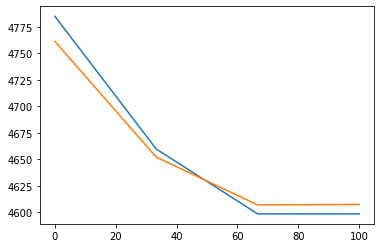

In [7]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 100, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

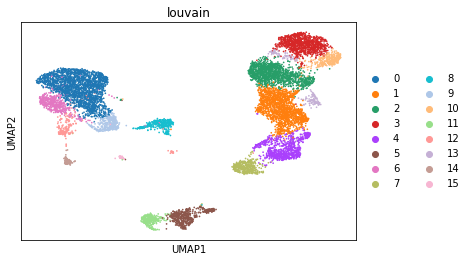

In [9]:

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
#cell_embeddings = pd.read_csv(input_path+'snare_p0_wnn_output.txt', sep="\t",index_col=0).iloc[:,[5,12]]
#prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list()
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

In [11]:

# save file
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation_no_pretrain.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=dataset.barcodes)
df.insert(0,"louvain",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"multivae_umap_no_pretrain.csv"))

df = pd.DataFrame(data=imputed_values[1].T, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_no_pretrain.csv"))

def binarization(imputed, raw):
    return (imputed.T > np.quantile(imputed,q=0.95,axis=1)).astype(np.int8)

atac_binary=binarization(imputed_values[1],dataset.atac_expression)
df = pd.DataFrame(data=atac_binary, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_binary.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=dataset.barcodes, index=dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation_no_pretrain.csv"))


In [6]:
# 进行预训练

# model para
#n_epochs = 30 if n_epochs_all is None else n_epochs_all
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0

# ATAC peak embedding
pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/pre_atac_trainer.pkl' % output_path):
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer.pkl' % output_path))
    pre_atac_trainer.model.eval()
else:
    pre_atac_trainer.train(n_epochs=10, lr=lr)
    torch.save(pre_atac_trainer.model.state_dict(), '%s/pre_atac_trainer.pkl' % output_path)
    pre_atac_trainer.model.eval()


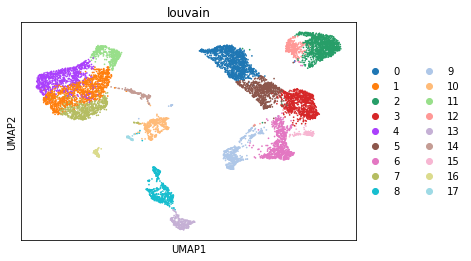

In [7]:

# ATAC pretrainer_posterior:
full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()



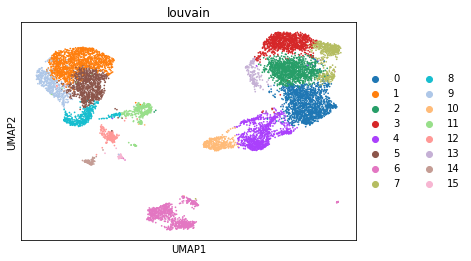

In [8]:
# RNA embedding
pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/pre_trainer.pkl' % output_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))
    pre_trainer.model.eval()

else:
    pre_trainer.train(n_epochs=10, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer.pkl' % output_path)
    pre_trainer.model.eval()

# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

df = pd.DataFrame(data=imputed_values.T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
 
# visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)


sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()


## multivae training

In [9]:
n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/multi_vae_trainer.pkl' % output_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_trainer.pkl' % output_path))
    trainer.model.eval()
else:
    pre_trainer = UnsupervisedTrainer(
        pre_vae,
        rna_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))

    pre_atac_trainer = UnsupervisedTrainer(
        pre_atac_vae,
        atac_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer.pkl' % output_path))

    n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

    # joint RNA and ATAC embedding
    trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

    trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
    for param in trainer.model.RNA_encoder.parameters():
        param.requires_grad = True
    trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
    for param in trainer.model.ATAC_encoder.parameters():
        param.requires_grad = True
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)
    trainer.model.eval()

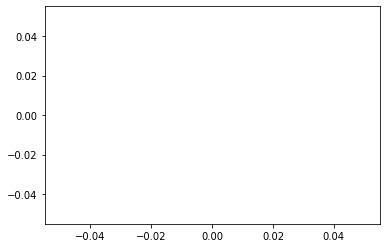

In [10]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 100, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()


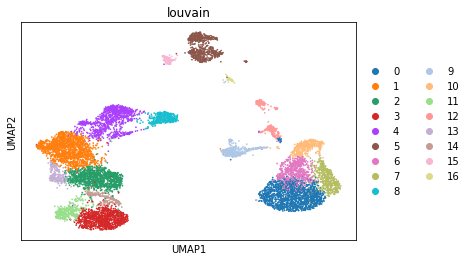

In [24]:
# 输出模型结果
# posterior

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
cell_embeddings = pd.read_csv(input_path+'pbmc_annotation_nmi.txt', sep="\t").iloc[:,[4,5]]
cell_embeddings.index=["{}-1".format(i) for i in cell_embeddings.index]

#prior_adata.obs['cell_type'] = cell_embeddings.loc[np.intersect1d(dataset.barcodes,cell_embeddings.index),"celltype"].to_list()
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

